# Custom models with PyTorch

This notebook illustrates how one can implement a time series model in GluonTS using PyTorch, train it with PyTorch Lightning, and use it together with the rest of the GluonTS ecosystem for data loading, feature processing, and model evaluation.

In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

For this example we will use the "electricity" dataset, which can be loaded as follows.

In [3]:
from gluonts.dataset.repository import get_dataset

In [4]:
dataset = get_dataset("electricity")

This is what the first time series from the training portion of the dataset look like:

/tmp/ipykernel_2997/1467569442.py:12: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))


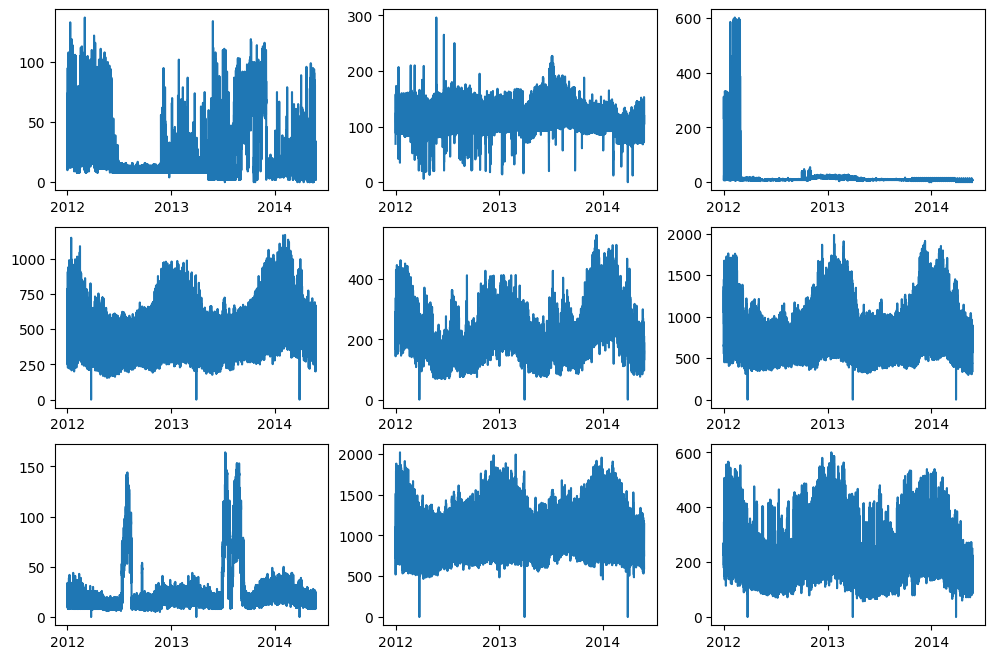

In [5]:
date_formater = mdates.DateFormatter("%Y")

fig = plt.figure(figsize=(12, 8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx + 1)
    t = pd.date_range(
        start=entry["start"].to_timestamp(),
        periods=len(entry["target"]),
        freq=entry["start"].freq,
    )
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

## Probabilistic feed-forward network using PyTorch

We will use a pretty simple model, based on a feed-forward network whose output layer produces the parameters of a parametric distribution. By default, the model will use a Student's t-distribution, but this can be easily customized via the `distr_output` constructor argument.

In [6]:
import torch
import torch.nn as nn

In [7]:
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator

In [8]:
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [9]:
class FeedForwardNetwork(nn.Module):
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        hidden_dimensions: List[int],
        distr_output=StudentTOutput(),
        batch_norm: bool = False,
        scaling: Callable = mean_abs_scaling,
    ) -> None:
        super().__init__()

        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dimensions) > 0

        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dimensions = hidden_dimensions
        self.distr_output = distr_output
        self.batch_norm = batch_norm
        self.scaling = scaling

        dimensions = [context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(out_size))
        modules.append(
            self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1])
        )

        self.nn = nn.Sequential(*modules)
        self.args_proj = self.distr_output.get_args_proj(hidden_dimensions[-1])

    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin

    def forward(self, past_target):
        scale = self.scaling(past_target)
        scaled_past_target = past_target / scale
        nn_out = self.nn(scaled_past_target)
        nn_out_reshaped = nn_out.reshape(
            -1, self.prediction_length, self.hidden_dimensions[-1]
        )
        distr_args = self.args_proj(nn_out_reshaped)
        return distr_args, torch.zeros_like(scale), scale

    def get_predictor(self, input_transform, batch_size=32):
        return PyTorchPredictor(
            prediction_length=self.prediction_length,
            input_names=["past_target"],
            prediction_net=self,
            batch_size=batch_size,
            input_transform=input_transform,
            forecast_generator=DistributionForecastGenerator(self.distr_output),
        )

To train the model using PyTorch Lightning, we only need to extend the class with methods that specify how training steps are supposed to work. Please refer to [documentation for PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) to know more about the interface you need to implement in order to fully customize the training procedure.

In [10]:
import lightning.pytorch as pl

In [11]:
class LightningFeedForwardNetwork(FeedForwardNetwork, pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        past_target = batch["past_target"]
        future_target = batch["future_target"]

        assert past_target.shape[-1] == self.context_length
        assert future_target.shape[-1] == self.prediction_length

        distr_args, loc, scale = self(past_target)
        distr = self.distr_output.distribution(distr_args, loc, scale)
        loss = -distr.log_prob(future_target)

        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

We can now instantiate the training network, and explore its set of parameters.

In [12]:
context_length = 2 * 7 * 24
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]

In [13]:
net = LightningFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=hidden_dimensions,
    distr_output=StudentTOutput(),
)

In [14]:
sum(np.prod(p.shape) for p in net.parameters())

144243

In [15]:
for p in net.parameters():
    print(p.shape)

torch.Size([96, 336])
torch.Size([96])
torch.Size([1152, 96])
torch.Size([1152])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])


## Defining the training data loader

We now set up the data loader which will yield batches of data to train on. Starting from the original dataset, the data loader is configured to apply the following transformation, which does essentially two things:
* Replaces `nan`s in the target field with a dummy value (zero), and adds a field indicating which values were actually observed vs imputed this way.
* Slices out training instances of a fixed length randomly from the given dataset; these will be stacked into batches by the data loader itself.

In [16]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddObservedValuesIndicator,
    InstanceSplitter,
    ExpectedNumInstanceSampler,
    TestSplitSampler,
)

In [17]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [18]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [19]:
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify

In [20]:
batch_size = 32
num_batches_per_epoch = 50

In [21]:
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

## Train the model

We can now train the model using the tooling that PyTorch Lightning provides:

In [22]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(net, data_loader)

INFO: GPU available: False, used: False


INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
INFO: 
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | nn        | Sequential | 144 K  | train
1 | args_proj | PtArgProj  | 147    | train
-------------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.577     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | nn        | Sequential | 144 K  | train
1 | args_proj | PtArgProj  | 147    | train
-------------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.577     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: |          | 0/? [00:00<?, ?it/s] 

Epoch 0: |          | 1/? [00:00<00:00, 20.33it/s]

Epoch 0: |          | 1/? [00:00<00:00, 20.05it/s, v_num=0]

Epoch 0: |          | 2/? [00:00<00:00, 17.38it/s, v_num=0]

Epoch 0: |          | 2/? [00:00<00:00, 17.28it/s, v_num=0]

Epoch 0: |          | 3/? [00:00<00:00, 16.64it/s, v_num=0]

Epoch 0: |          | 3/? [00:00<00:00, 16.57it/s, v_num=0]

Epoch 0: |          | 4/? [00:00<00:00, 16.41it/s, v_num=0]

Epoch 0: |          | 4/? [00:00<00:00, 16.37it/s, v_num=0]

Epoch 0: |          | 5/? [00:00<00:00, 15.86it/s, v_num=0]

Epoch 0: |          | 5/? [00:00<00:00, 15.82it/s, v_num=0]

Epoch 0: |          | 6/? [00:00<00:00, 15.81it/s, v_num=0]

Epoch 0: |          | 6/? [00:00<00:00, 15.78it/s, v_num=0]

Epoch 0: |          | 7/? [00:00<00:00, 16.09it/s, v_num=0]

Epoch 0: |          | 7/? [00:00<00:00, 16.06it/s, v_num=0]

Epoch 0: |          | 8/? [00:00<00:00, 16.30it/s, v_num=0]

Epoch 0: |          | 8/? [00:00<00:00, 16.28it/s, v_num=0]

Epoch 0: |          | 9/? [00:00<00:00, 16.16it/s, v_num=0]

Epoch 0: |          | 9/? [00:00<00:00, 16.14it/s, v_num=0]

Epoch 0: |          | 10/? [00:00<00:00, 17.24it/s, v_num=0]

Epoch 0: |          | 10/? [00:00<00:00, 17.22it/s, v_num=0]

Epoch 0: |          | 11/? [00:00<00:00, 18.62it/s, v_num=0]

Epoch 0: |          | 11/? [00:00<00:00, 18.60it/s, v_num=0]

Epoch 0: |          | 12/? [00:00<00:00, 19.96it/s, v_num=0]

Epoch 0: |          | 12/? [00:00<00:00, 19.94it/s, v_num=0]

Epoch 0: |          | 13/? [00:00<00:00, 21.23it/s, v_num=0]

Epoch 0: |          | 13/? [00:00<00:00, 21.21it/s, v_num=0]

Epoch 0: |          | 14/? [00:00<00:00, 22.46it/s, v_num=0]

Epoch 0: |          | 14/? [00:00<00:00, 22.44it/s, v_num=0]

Epoch 0: |          | 15/? [00:00<00:00, 23.70it/s, v_num=0]

Epoch 0: |          | 15/? [00:00<00:00, 23.67it/s, v_num=0]

Epoch 0: |          | 16/? [00:00<00:00, 24.87it/s, v_num=0]

Epoch 0: |          | 16/? [00:00<00:00, 24.85it/s, v_num=0]

Epoch 0: |          | 17/? [00:00<00:00, 26.03it/s, v_num=0]

Epoch 0: |          | 17/? [00:00<00:00, 26.01it/s, v_num=0]

Epoch 0: |          | 18/? [00:00<00:00, 27.17it/s, v_num=0]

Epoch 0: |          | 18/? [00:00<00:00, 27.15it/s, v_num=0]

Epoch 0: |          | 19/? [00:00<00:00, 28.26it/s, v_num=0]

Epoch 0: |          | 19/? [00:00<00:00, 28.23it/s, v_num=0]

Epoch 0: |          | 20/? [00:00<00:00, 29.16it/s, v_num=0]

Epoch 0: |          | 20/? [00:00<00:00, 29.13it/s, v_num=0]

Epoch 0: |          | 21/? [00:00<00:00, 30.01it/s, v_num=0]

Epoch 0: |          | 21/? [00:00<00:00, 29.99it/s, v_num=0]

Epoch 0: |          | 22/? [00:00<00:00, 30.83it/s, v_num=0]

Epoch 0: |          | 22/? [00:00<00:00, 30.80it/s, v_num=0]

Epoch 0: |          | 23/? [00:00<00:00, 31.57it/s, v_num=0]

Epoch 0: |          | 23/? [00:00<00:00, 31.55it/s, v_num=0]

Epoch 0: |          | 24/? [00:00<00:00, 32.41it/s, v_num=0]

Epoch 0: |          | 24/? [00:00<00:00, 32.39it/s, v_num=0]

Epoch 0: |          | 25/? [00:00<00:00, 33.20it/s, v_num=0]

Epoch 0: |          | 25/? [00:00<00:00, 33.17it/s, v_num=0]

Epoch 0: |          | 26/? [00:00<00:00, 34.09it/s, v_num=0]

Epoch 0: |          | 26/? [00:00<00:00, 34.06it/s, v_num=0]

Epoch 0: |          | 27/? [00:00<00:00, 34.88it/s, v_num=0]

Epoch 0: |          | 27/? [00:00<00:00, 34.86it/s, v_num=0]

Epoch 0: |          | 28/? [00:00<00:00, 35.65it/s, v_num=0]

Epoch 0: |          | 28/? [00:00<00:00, 35.62it/s, v_num=0]

Epoch 0: |          | 29/? [00:00<00:00, 36.45it/s, v_num=0]

Epoch 0: |          | 29/? [00:00<00:00, 36.42it/s, v_num=0]

Epoch 0: |          | 30/? [00:00<00:00, 37.11it/s, v_num=0]

Epoch 0: |          | 30/? [00:00<00:00, 37.08it/s, v_num=0]

Epoch 0: |          | 31/? [00:00<00:00, 37.88it/s, v_num=0]

Epoch 0: |          | 31/? [00:00<00:00, 37.86it/s, v_num=0]

Epoch 0: |          | 32/? [00:00<00:00, 38.55it/s, v_num=0]

Epoch 0: |          | 32/? [00:00<00:00, 38.52it/s, v_num=0]

Epoch 0: |          | 33/? [00:00<00:00, 39.20it/s, v_num=0]

Epoch 0: |          | 33/? [00:00<00:00, 39.17it/s, v_num=0]

Epoch 0: |          | 34/? [00:00<00:00, 39.91it/s, v_num=0]

Epoch 0: |          | 34/? [00:00<00:00, 39.88it/s, v_num=0]

Epoch 0: |          | 35/? [00:00<00:00, 40.59it/s, v_num=0]

Epoch 0: |          | 35/? [00:00<00:00, 40.56it/s, v_num=0]

Epoch 0: |          | 36/? [00:00<00:00, 41.24it/s, v_num=0]

Epoch 0: |          | 36/? [00:00<00:00, 41.21it/s, v_num=0]

Epoch 0: |          | 37/? [00:00<00:00, 41.78it/s, v_num=0]

Epoch 0: |          | 37/? [00:00<00:00, 41.75it/s, v_num=0]

Epoch 0: |          | 38/? [00:00<00:00, 42.39it/s, v_num=0]

Epoch 0: |          | 38/? [00:00<00:00, 42.37it/s, v_num=0]

Epoch 0: |          | 39/? [00:00<00:00, 42.98it/s, v_num=0]

Epoch 0: |          | 39/? [00:00<00:00, 42.96it/s, v_num=0]

Epoch 0: |          | 40/? [00:00<00:00, 43.60it/s, v_num=0]

Epoch 0: |          | 40/? [00:00<00:00, 43.57it/s, v_num=0]

Epoch 0: |          | 41/? [00:00<00:00, 44.14it/s, v_num=0]

Epoch 0: |          | 41/? [00:00<00:00, 44.11it/s, v_num=0]

Epoch 0: |          | 42/? [00:00<00:00, 44.80it/s, v_num=0]

Epoch 0: |          | 42/? [00:00<00:00, 44.76it/s, v_num=0]

Epoch 0: |          | 43/? [00:00<00:00, 45.31it/s, v_num=0]

Epoch 0: |          | 43/? [00:00<00:00, 45.29it/s, v_num=0]

Epoch 0: |          | 44/? [00:00<00:00, 45.83it/s, v_num=0]

Epoch 0: |          | 44/? [00:00<00:00, 45.80it/s, v_num=0]

Epoch 0: |          | 45/? [00:00<00:00, 46.33it/s, v_num=0]

Epoch 0: |          | 45/? [00:00<00:00, 46.31it/s, v_num=0]

Epoch 0: |          | 46/? [00:00<00:00, 46.90it/s, v_num=0]

Epoch 0: |          | 46/? [00:00<00:00, 46.88it/s, v_num=0]

Epoch 0: |          | 47/? [00:00<00:00, 47.37it/s, v_num=0]

Epoch 0: |          | 47/? [00:00<00:00, 47.34it/s, v_num=0]

Epoch 0: |          | 48/? [00:01<00:00, 47.92it/s, v_num=0]

Epoch 0: |          | 48/? [00:01<00:00, 47.89it/s, v_num=0]

Epoch 0: |          | 49/? [00:01<00:00, 48.38it/s, v_num=0]

Epoch 0: |          | 49/? [00:01<00:00, 48.36it/s, v_num=0]

Epoch 0: |          | 50/? [00:01<00:00, 49.14it/s, v_num=0]

Epoch 0: |          | 50/? [00:01<00:00, 49.11it/s, v_num=0]

Epoch 0: |          | 50/? [00:01<00:00, 49.06it/s, v_num=0]

Epoch 0: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 1: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 1: |          | 1/? [00:00<00:00, 69.50it/s, v_num=0]

Epoch 1: |          | 1/? [00:00<00:00, 66.65it/s, v_num=0]

Epoch 1: |          | 2/? [00:00<00:00, 83.88it/s, v_num=0]

Epoch 1: |          | 2/? [00:00<00:00, 81.92it/s, v_num=0]

Epoch 1: |          | 3/? [00:00<00:00, 87.74it/s, v_num=0]

Epoch 1: |          | 3/? [00:00<00:00, 86.23it/s, v_num=0]

Epoch 1: |          | 4/? [00:00<00:00, 89.21it/s, v_num=0]

Epoch 1: |          | 4/? [00:00<00:00, 88.02it/s, v_num=0]

Epoch 1: |          | 5/? [00:00<00:00, 89.85it/s, v_num=0]

Epoch 1: |          | 5/? [00:00<00:00, 88.88it/s, v_num=0]

Epoch 1: |          | 6/? [00:00<00:00, 90.65it/s, v_num=0]

Epoch 1: |          | 6/? [00:00<00:00, 89.91it/s, v_num=0]

Epoch 1: |          | 7/? [00:00<00:00, 90.46it/s, v_num=0]

Epoch 1: |          | 7/? [00:00<00:00, 89.76it/s, v_num=0]

Epoch 1: |          | 8/? [00:00<00:00, 92.19it/s, v_num=0]

Epoch 1: |          | 8/? [00:00<00:00, 91.57it/s, v_num=0]

Epoch 1: |          | 9/? [00:00<00:00, 92.42it/s, v_num=0]

Epoch 1: |          | 9/? [00:00<00:00, 91.84it/s, v_num=0]

Epoch 1: |          | 10/? [00:00<00:00, 91.93it/s, v_num=0]

Epoch 1: |          | 10/? [00:00<00:00, 91.42it/s, v_num=0]

Epoch 1: |          | 11/? [00:00<00:00, 92.64it/s, v_num=0]

Epoch 1: |          | 11/? [00:00<00:00, 92.19it/s, v_num=0]

Epoch 1: |          | 12/? [00:00<00:00, 91.13it/s, v_num=0]

Epoch 1: |          | 12/? [00:00<00:00, 90.70it/s, v_num=0]

Epoch 1: |          | 13/? [00:00<00:00, 90.49it/s, v_num=0]

Epoch 1: |          | 13/? [00:00<00:00, 90.11it/s, v_num=0]

Epoch 1: |          | 14/? [00:00<00:00, 89.97it/s, v_num=0]

Epoch 1: |          | 14/? [00:00<00:00, 89.62it/s, v_num=0]

Epoch 1: |          | 15/? [00:00<00:00, 90.50it/s, v_num=0]

Epoch 1: |          | 15/? [00:00<00:00, 90.17it/s, v_num=0]

Epoch 1: |          | 16/? [00:00<00:00, 90.96it/s, v_num=0]

Epoch 1: |          | 16/? [00:00<00:00, 90.65it/s, v_num=0]

Epoch 1: |          | 17/? [00:00<00:00, 91.69it/s, v_num=0]

Epoch 1: |          | 17/? [00:00<00:00, 91.40it/s, v_num=0]

Epoch 1: |          | 18/? [00:00<00:00, 92.52it/s, v_num=0]

Epoch 1: |          | 18/? [00:00<00:00, 92.25it/s, v_num=0]

Epoch 1: |          | 19/? [00:00<00:00, 92.06it/s, v_num=0]

Epoch 1: |          | 19/? [00:00<00:00, 91.79it/s, v_num=0]

Epoch 1: |          | 20/? [00:00<00:00, 91.82it/s, v_num=0]

Epoch 1: |          | 20/? [00:00<00:00, 91.57it/s, v_num=0]

Epoch 1: |          | 21/? [00:00<00:00, 91.81it/s, v_num=0]

Epoch 1: |          | 21/? [00:00<00:00, 91.54it/s, v_num=0]

Epoch 1: |          | 22/? [00:00<00:00, 91.10it/s, v_num=0]

Epoch 1: |          | 22/? [00:00<00:00, 90.86it/s, v_num=0]

Epoch 1: |          | 23/? [00:00<00:00, 91.45it/s, v_num=0]

Epoch 1: |          | 23/? [00:00<00:00, 91.22it/s, v_num=0]

Epoch 1: |          | 24/? [00:00<00:00, 91.32it/s, v_num=0]

Epoch 1: |          | 24/? [00:00<00:00, 91.13it/s, v_num=0]

Epoch 1: |          | 25/? [00:00<00:00, 91.32it/s, v_num=0]

Epoch 1: |          | 25/? [00:00<00:00, 91.14it/s, v_num=0]

Epoch 1: |          | 26/? [00:00<00:00, 91.35it/s, v_num=0]

Epoch 1: |          | 26/? [00:00<00:00, 91.16it/s, v_num=0]

Epoch 1: |          | 27/? [00:00<00:00, 91.76it/s, v_num=0]

Epoch 1: |          | 27/? [00:00<00:00, 91.59it/s, v_num=0]

Epoch 1: |          | 28/? [00:00<00:00, 92.13it/s, v_num=0]

Epoch 1: |          | 28/? [00:00<00:00, 91.97it/s, v_num=0]

Epoch 1: |          | 29/? [00:00<00:00, 92.04it/s, v_num=0]

Epoch 1: |          | 29/? [00:00<00:00, 91.87it/s, v_num=0]

Epoch 1: |          | 30/? [00:00<00:00, 92.08it/s, v_num=0]

Epoch 1: |          | 30/? [00:00<00:00, 91.88it/s, v_num=0]

Epoch 1: |          | 31/? [00:00<00:00, 92.10it/s, v_num=0]

Epoch 1: |          | 31/? [00:00<00:00, 91.95it/s, v_num=0]

Epoch 1: |          | 32/? [00:00<00:00, 92.10it/s, v_num=0]

Epoch 1: |          | 32/? [00:00<00:00, 91.95it/s, v_num=0]

Epoch 1: |          | 33/? [00:00<00:00, 91.61it/s, v_num=0]

Epoch 1: |          | 33/? [00:00<00:00, 91.48it/s, v_num=0]

Epoch 1: |          | 34/? [00:00<00:00, 91.83it/s, v_num=0]

Epoch 1: |          | 34/? [00:00<00:00, 91.69it/s, v_num=0]

Epoch 1: |          | 35/? [00:00<00:00, 91.87it/s, v_num=0]

Epoch 1: |          | 35/? [00:00<00:00, 91.73it/s, v_num=0]

Epoch 1: |          | 36/? [00:00<00:00, 92.19it/s, v_num=0]

Epoch 1: |          | 36/? [00:00<00:00, 92.06it/s, v_num=0]

Epoch 1: |          | 37/? [00:00<00:00, 92.34it/s, v_num=0]

Epoch 1: |          | 37/? [00:00<00:00, 92.19it/s, v_num=0]

Epoch 1: |          | 38/? [00:00<00:00, 92.34it/s, v_num=0]

Epoch 1: |          | 38/? [00:00<00:00, 92.20it/s, v_num=0]

Epoch 1: |          | 39/? [00:00<00:00, 92.35it/s, v_num=0]

Epoch 1: |          | 39/? [00:00<00:00, 92.23it/s, v_num=0]

Epoch 1: |          | 40/? [00:00<00:00, 92.37it/s, v_num=0]

Epoch 1: |          | 40/? [00:00<00:00, 92.25it/s, v_num=0]

Epoch 1: |          | 41/? [00:00<00:00, 92.58it/s, v_num=0]

Epoch 1: |          | 41/? [00:00<00:00, 92.47it/s, v_num=0]

Epoch 1: |          | 42/? [00:00<00:00, 92.75it/s, v_num=0]

Epoch 1: |          | 42/? [00:00<00:00, 92.64it/s, v_num=0]

Epoch 1: |          | 43/? [00:00<00:00, 92.87it/s, v_num=0]

Epoch 1: |          | 43/? [00:00<00:00, 92.76it/s, v_num=0]

Epoch 1: |          | 44/? [00:00<00:00, 93.02it/s, v_num=0]

Epoch 1: |          | 44/? [00:00<00:00, 92.90it/s, v_num=0]

Epoch 1: |          | 45/? [00:00<00:00, 93.20it/s, v_num=0]

Epoch 1: |          | 45/? [00:00<00:00, 93.08it/s, v_num=0]

Epoch 1: |          | 46/? [00:00<00:00, 92.98it/s, v_num=0]

Epoch 1: |          | 46/? [00:00<00:00, 92.86it/s, v_num=0]

Epoch 1: |          | 47/? [00:00<00:00, 92.87it/s, v_num=0]

Epoch 1: |          | 47/? [00:00<00:00, 92.76it/s, v_num=0]

Epoch 1: |          | 48/? [00:00<00:00, 92.71it/s, v_num=0]

Epoch 1: |          | 48/? [00:00<00:00, 92.60it/s, v_num=0]

Epoch 1: |          | 49/? [00:00<00:00, 92.71it/s, v_num=0]

Epoch 1: |          | 49/? [00:00<00:00, 92.60it/s, v_num=0]

Epoch 1: |          | 50/? [00:00<00:00, 93.72it/s, v_num=0]

Epoch 1: |          | 50/? [00:00<00:00, 93.62it/s, v_num=0]

Epoch 1: |          | 50/? [00:00<00:00, 93.51it/s, v_num=0]

Epoch 1: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 2: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 2: |          | 1/? [00:00<00:00, 64.45it/s, v_num=0]

Epoch 2: |          | 1/? [00:00<00:00, 61.92it/s, v_num=0]

Epoch 2: |          | 2/? [00:00<00:00, 70.60it/s, v_num=0]

Epoch 2: |          | 2/? [00:00<00:00, 69.09it/s, v_num=0]

Epoch 2: |          | 3/? [00:00<00:00, 70.48it/s, v_num=0]

Epoch 2: |          | 3/? [00:00<00:00, 69.60it/s, v_num=0]

Epoch 2: |          | 4/? [00:00<00:00, 76.05it/s, v_num=0]

Epoch 2: |          | 4/? [00:00<00:00, 75.17it/s, v_num=0]

Epoch 2: |          | 5/? [00:00<00:00, 80.18it/s, v_num=0]

Epoch 2: |          | 5/? [00:00<00:00, 79.42it/s, v_num=0]

Epoch 2: |          | 6/? [00:00<00:00, 83.96it/s, v_num=0]

Epoch 2: |          | 6/? [00:00<00:00, 83.27it/s, v_num=0]

Epoch 2: |          | 7/? [00:00<00:00, 86.86it/s, v_num=0]

Epoch 2: |          | 7/? [00:00<00:00, 86.21it/s, v_num=0]

Epoch 2: |          | 8/? [00:00<00:00, 89.20it/s, v_num=0]

Epoch 2: |          | 8/? [00:00<00:00, 88.60it/s, v_num=0]

Epoch 2: |          | 9/? [00:00<00:00, 89.47it/s, v_num=0]

Epoch 2: |          | 9/? [00:00<00:00, 88.90it/s, v_num=0]

Epoch 2: |          | 10/? [00:00<00:00, 90.54it/s, v_num=0]

Epoch 2: |          | 10/? [00:00<00:00, 90.06it/s, v_num=0]

Epoch 2: |          | 11/? [00:00<00:00, 90.71it/s, v_num=0]

Epoch 2: |          | 11/? [00:00<00:00, 90.27it/s, v_num=0]

Epoch 2: |          | 12/? [00:00<00:00, 89.52it/s, v_num=0]

Epoch 2: |          | 12/? [00:00<00:00, 89.16it/s, v_num=0]

Epoch 2: |          | 13/? [00:00<00:00, 87.88it/s, v_num=0]

Epoch 2: |          | 13/? [00:00<00:00, 87.52it/s, v_num=0]

Epoch 2: |          | 14/? [00:00<00:00, 86.61it/s, v_num=0]

Epoch 2: |          | 14/? [00:00<00:00, 86.29it/s, v_num=0]

Epoch 2: |          | 15/? [00:00<00:00, 86.58it/s, v_num=0]

Epoch 2: |          | 15/? [00:00<00:00, 86.27it/s, v_num=0]

Epoch 2: |          | 16/? [00:00<00:00, 87.34it/s, v_num=0]

Epoch 2: |          | 16/? [00:00<00:00, 87.05it/s, v_num=0]

Epoch 2: |          | 17/? [00:00<00:00, 88.16it/s, v_num=0]

Epoch 2: |          | 17/? [00:00<00:00, 87.89it/s, v_num=0]

Epoch 2: |          | 18/? [00:00<00:00, 88.66it/s, v_num=0]

Epoch 2: |          | 18/? [00:00<00:00, 88.40it/s, v_num=0]

Epoch 2: |          | 19/? [00:00<00:00, 89.00it/s, v_num=0]

Epoch 2: |          | 19/? [00:00<00:00, 88.75it/s, v_num=0]

Epoch 2: |          | 20/? [00:00<00:00, 88.29it/s, v_num=0]

Epoch 2: |          | 20/? [00:00<00:00, 88.05it/s, v_num=0]

Epoch 2: |          | 21/? [00:00<00:00, 89.00it/s, v_num=0]

Epoch 2: |          | 21/? [00:00<00:00, 88.77it/s, v_num=0]

Epoch 2: |          | 22/? [00:00<00:00, 89.20it/s, v_num=0]

Epoch 2: |          | 22/? [00:00<00:00, 88.99it/s, v_num=0]

Epoch 2: |          | 23/? [00:00<00:00, 89.26it/s, v_num=0]

Epoch 2: |          | 23/? [00:00<00:00, 89.06it/s, v_num=0]

Epoch 2: |          | 24/? [00:00<00:00, 89.50it/s, v_num=0]

Epoch 2: |          | 24/? [00:00<00:00, 89.30it/s, v_num=0]

Epoch 2: |          | 25/? [00:00<00:00, 89.83it/s, v_num=0]

Epoch 2: |          | 25/? [00:00<00:00, 89.63it/s, v_num=0]

Epoch 2: |          | 26/? [00:00<00:00, 90.42it/s, v_num=0]

Epoch 2: |          | 26/? [00:00<00:00, 90.24it/s, v_num=0]

Epoch 2: |          | 27/? [00:00<00:00, 90.84it/s, v_num=0]

Epoch 2: |          | 27/? [00:00<00:00, 90.66it/s, v_num=0]

Epoch 2: |          | 28/? [00:00<00:00, 90.60it/s, v_num=0]

Epoch 2: |          | 28/? [00:00<00:00, 90.42it/s, v_num=0]

Epoch 2: |          | 29/? [00:00<00:00, 90.74it/s, v_num=0]

Epoch 2: |          | 29/? [00:00<00:00, 90.57it/s, v_num=0]

Epoch 2: |          | 30/? [00:00<00:00, 91.25it/s, v_num=0]

Epoch 2: |          | 30/? [00:00<00:00, 91.10it/s, v_num=0]

Epoch 2: |          | 31/? [00:00<00:00, 91.25it/s, v_num=0]

Epoch 2: |          | 31/? [00:00<00:00, 91.10it/s, v_num=0]

Epoch 2: |          | 32/? [00:00<00:00, 91.41it/s, v_num=0]

Epoch 2: |          | 32/? [00:00<00:00, 91.25it/s, v_num=0]

Epoch 2: |          | 33/? [00:00<00:00, 91.76it/s, v_num=0]

Epoch 2: |          | 33/? [00:00<00:00, 91.60it/s, v_num=0]

Epoch 2: |          | 34/? [00:00<00:00, 91.89it/s, v_num=0]

Epoch 2: |          | 34/? [00:00<00:00, 91.73it/s, v_num=0]

Epoch 2: |          | 35/? [00:00<00:00, 91.54it/s, v_num=0]

Epoch 2: |          | 35/? [00:00<00:00, 91.40it/s, v_num=0]

Epoch 2: |          | 36/? [00:00<00:00, 91.79it/s, v_num=0]

Epoch 2: |          | 36/? [00:00<00:00, 91.64it/s, v_num=0]

Epoch 2: |          | 37/? [00:00<00:00, 92.09it/s, v_num=0]

Epoch 2: |          | 37/? [00:00<00:00, 91.96it/s, v_num=0]

Epoch 2: |          | 38/? [00:00<00:00, 91.80it/s, v_num=0]

Epoch 2: |          | 38/? [00:00<00:00, 91.66it/s, v_num=0]

Epoch 2: |          | 39/? [00:00<00:00, 91.83it/s, v_num=0]

Epoch 2: |          | 39/? [00:00<00:00, 91.71it/s, v_num=0]

Epoch 2: |          | 40/? [00:00<00:00, 92.08it/s, v_num=0]

Epoch 2: |          | 40/? [00:00<00:00, 91.95it/s, v_num=0]

Epoch 2: |          | 41/? [00:00<00:00, 92.05it/s, v_num=0]

Epoch 2: |          | 41/? [00:00<00:00, 91.93it/s, v_num=0]

Epoch 2: |          | 42/? [00:00<00:00, 92.35it/s, v_num=0]

Epoch 2: |          | 42/? [00:00<00:00, 92.23it/s, v_num=0]

Epoch 2: |          | 43/? [00:00<00:00, 92.49it/s, v_num=0]

Epoch 2: |          | 43/? [00:00<00:00, 92.38it/s, v_num=0]

Epoch 2: |          | 44/? [00:00<00:00, 92.70it/s, v_num=0]

Epoch 2: |          | 44/? [00:00<00:00, 92.57it/s, v_num=0]

Epoch 2: |          | 45/? [00:00<00:00, 92.14it/s, v_num=0]

Epoch 2: |          | 45/? [00:00<00:00, 92.01it/s, v_num=0]

Epoch 2: |          | 46/? [00:00<00:00, 92.17it/s, v_num=0]

Epoch 2: |          | 46/? [00:00<00:00, 92.07it/s, v_num=0]

Epoch 2: |          | 47/? [00:00<00:00, 92.34it/s, v_num=0]

Epoch 2: |          | 47/? [00:00<00:00, 92.24it/s, v_num=0]

Epoch 2: |          | 48/? [00:00<00:00, 92.52it/s, v_num=0]

Epoch 2: |          | 48/? [00:00<00:00, 92.42it/s, v_num=0]

Epoch 2: |          | 49/? [00:00<00:00, 92.35it/s, v_num=0]

Epoch 2: |          | 49/? [00:00<00:00, 92.26it/s, v_num=0]

Epoch 2: |          | 50/? [00:00<00:00, 93.36it/s, v_num=0]

Epoch 2: |          | 50/? [00:00<00:00, 93.27it/s, v_num=0]

Epoch 2: |          | 50/? [00:00<00:00, 93.15it/s, v_num=0]

Epoch 2: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 3: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 3: |          | 1/? [00:00<00:00, 66.94it/s, v_num=0]

Epoch 3: |          | 1/? [00:00<00:00, 64.48it/s, v_num=0]

Epoch 3: |          | 2/? [00:00<00:00, 78.79it/s, v_num=0]

Epoch 3: |          | 2/? [00:00<00:00, 77.08it/s, v_num=0]

Epoch 3: |          | 3/? [00:00<00:00, 85.45it/s, v_num=0]

Epoch 3: |          | 3/? [00:00<00:00, 84.11it/s, v_num=0]

Epoch 3: |          | 4/? [00:00<00:00, 90.54it/s, v_num=0]

Epoch 3: |          | 4/? [00:00<00:00, 89.37it/s, v_num=0]

Epoch 3: |          | 5/? [00:00<00:00, 92.25it/s, v_num=0]

Epoch 3: |          | 5/? [00:00<00:00, 91.28it/s, v_num=0]

Epoch 3: |          | 6/? [00:00<00:00, 94.07it/s, v_num=0]

Epoch 3: |          | 6/? [00:00<00:00, 93.27it/s, v_num=0]

Epoch 3: |          | 7/? [00:00<00:00, 91.54it/s, v_num=0]

Epoch 3: |          | 7/? [00:00<00:00, 90.91it/s, v_num=0]

Epoch 3: |          | 8/? [00:00<00:00, 92.18it/s, v_num=0]

Epoch 3: |          | 8/? [00:00<00:00, 91.55it/s, v_num=0]

Epoch 3: |          | 9/? [00:00<00:00, 92.32it/s, v_num=0]

Epoch 3: |          | 9/? [00:00<00:00, 91.73it/s, v_num=0]

Epoch 3: |          | 10/? [00:00<00:00, 92.94it/s, v_num=0]

Epoch 3: |          | 10/? [00:00<00:00, 92.26it/s, v_num=0]

Epoch 3: |          | 11/? [00:00<00:00, 92.49it/s, v_num=0]

Epoch 3: |          | 11/? [00:00<00:00, 92.02it/s, v_num=0]

Epoch 3: |          | 12/? [00:00<00:00, 92.04it/s, v_num=0]

Epoch 3: |          | 12/? [00:00<00:00, 91.59it/s, v_num=0]

Epoch 3: |          | 13/? [00:00<00:00, 92.06it/s, v_num=0]

Epoch 3: |          | 13/? [00:00<00:00, 91.71it/s, v_num=0]

Epoch 3: |          | 14/? [00:00<00:00, 91.72it/s, v_num=0]

Epoch 3: |          | 14/? [00:00<00:00, 91.38it/s, v_num=0]

Epoch 3: |          | 15/? [00:00<00:00, 92.63it/s, v_num=0]

Epoch 3: |          | 15/? [00:00<00:00, 92.31it/s, v_num=0]

Epoch 3: |          | 16/? [00:00<00:00, 92.59it/s, v_num=0]

Epoch 3: |          | 16/? [00:00<00:00, 92.28it/s, v_num=0]

Epoch 3: |          | 17/? [00:00<00:00, 92.94it/s, v_num=0]

Epoch 3: |          | 17/? [00:00<00:00, 92.64it/s, v_num=0]

Epoch 3: |          | 18/? [00:00<00:00, 93.71it/s, v_num=0]

Epoch 3: |          | 18/? [00:00<00:00, 93.47it/s, v_num=0]

Epoch 3: |          | 19/? [00:00<00:00, 94.08it/s, v_num=0]

Epoch 3: |          | 19/? [00:00<00:00, 93.82it/s, v_num=0]

Epoch 3: |          | 20/? [00:00<00:00, 94.51it/s, v_num=0]

Epoch 3: |          | 20/? [00:00<00:00, 94.25it/s, v_num=0]

Epoch 3: |          | 21/? [00:00<00:00, 94.69it/s, v_num=0]

Epoch 3: |          | 21/? [00:00<00:00, 94.46it/s, v_num=0]

Epoch 3: |          | 22/? [00:00<00:00, 95.61it/s, v_num=0]

Epoch 3: |          | 22/? [00:00<00:00, 95.37it/s, v_num=0]

Epoch 3: |          | 23/? [00:00<00:00, 95.43it/s, v_num=0]

Epoch 3: |          | 23/? [00:00<00:00, 95.21it/s, v_num=0]

Epoch 3: |          | 24/? [00:00<00:00, 95.30it/s, v_num=0]

Epoch 3: |          | 24/? [00:00<00:00, 95.09it/s, v_num=0]

Epoch 3: |          | 25/? [00:00<00:00, 95.39it/s, v_num=0]

Epoch 3: |          | 25/? [00:00<00:00, 95.19it/s, v_num=0]

Epoch 3: |          | 26/? [00:00<00:00, 95.76it/s, v_num=0]

Epoch 3: |          | 26/? [00:00<00:00, 95.55it/s, v_num=0]

Epoch 3: |          | 27/? [00:00<00:00, 96.04it/s, v_num=0]

Epoch 3: |          | 27/? [00:00<00:00, 95.85it/s, v_num=0]

Epoch 3: |          | 28/? [00:00<00:00, 95.93it/s, v_num=0]

Epoch 3: |          | 28/? [00:00<00:00, 95.74it/s, v_num=0]

Epoch 3: |          | 29/? [00:00<00:00, 96.09it/s, v_num=0]

Epoch 3: |          | 29/? [00:00<00:00, 95.90it/s, v_num=0]

Epoch 3: |          | 30/? [00:00<00:00, 96.13it/s, v_num=0]

Epoch 3: |          | 30/? [00:00<00:00, 95.95it/s, v_num=0]

Epoch 3: |          | 31/? [00:00<00:00, 95.97it/s, v_num=0]

Epoch 3: |          | 31/? [00:00<00:00, 95.80it/s, v_num=0]

Epoch 3: |          | 32/? [00:00<00:00, 95.74it/s, v_num=0]

Epoch 3: |          | 32/? [00:00<00:00, 95.57it/s, v_num=0]

Epoch 3: |          | 33/? [00:00<00:00, 95.53it/s, v_num=0]

Epoch 3: |          | 33/? [00:00<00:00, 95.36it/s, v_num=0]

Epoch 3: |          | 34/? [00:00<00:00, 94.19it/s, v_num=0]

Epoch 3: |          | 34/? [00:00<00:00, 94.02it/s, v_num=0]

Epoch 3: |          | 35/? [00:00<00:00, 93.66it/s, v_num=0]

Epoch 3: |          | 35/? [00:00<00:00, 93.50it/s, v_num=0]

Epoch 3: |          | 36/? [00:00<00:00, 92.98it/s, v_num=0]

Epoch 3: |          | 36/? [00:00<00:00, 92.86it/s, v_num=0]

Epoch 3: |          | 37/? [00:00<00:00, 92.66it/s, v_num=0]

Epoch 3: |          | 37/? [00:00<00:00, 92.53it/s, v_num=0]

Epoch 3: |          | 38/? [00:00<00:00, 93.06it/s, v_num=0]

Epoch 3: |          | 38/? [00:00<00:00, 92.93it/s, v_num=0]

Epoch 3: |          | 39/? [00:00<00:00, 93.33it/s, v_num=0]

Epoch 3: |          | 39/? [00:00<00:00, 93.20it/s, v_num=0]

Epoch 3: |          | 40/? [00:00<00:00, 93.55it/s, v_num=0]

Epoch 3: |          | 40/? [00:00<00:00, 93.43it/s, v_num=0]

Epoch 3: |          | 41/? [00:00<00:00, 93.60it/s, v_num=0]

Epoch 3: |          | 41/? [00:00<00:00, 93.49it/s, v_num=0]

Epoch 3: |          | 42/? [00:00<00:00, 93.72it/s, v_num=0]

Epoch 3: |          | 42/? [00:00<00:00, 93.60it/s, v_num=0]

Epoch 3: |          | 43/? [00:00<00:00, 93.99it/s, v_num=0]

Epoch 3: |          | 43/? [00:00<00:00, 93.88it/s, v_num=0]

Epoch 3: |          | 44/? [00:00<00:00, 93.98it/s, v_num=0]

Epoch 3: |          | 44/? [00:00<00:00, 93.86it/s, v_num=0]

Epoch 3: |          | 45/? [00:00<00:00, 93.92it/s, v_num=0]

Epoch 3: |          | 45/? [00:00<00:00, 93.82it/s, v_num=0]

Epoch 3: |          | 46/? [00:00<00:00, 93.72it/s, v_num=0]

Epoch 3: |          | 46/? [00:00<00:00, 93.62it/s, v_num=0]

Epoch 3: |          | 47/? [00:00<00:00, 93.78it/s, v_num=0]

Epoch 3: |          | 47/? [00:00<00:00, 93.68it/s, v_num=0]

Epoch 3: |          | 48/? [00:00<00:00, 93.97it/s, v_num=0]

Epoch 3: |          | 48/? [00:00<00:00, 93.88it/s, v_num=0]

Epoch 3: |          | 49/? [00:00<00:00, 94.20it/s, v_num=0]

Epoch 3: |          | 49/? [00:00<00:00, 94.10it/s, v_num=0]

Epoch 3: |          | 50/? [00:00<00:00, 95.24it/s, v_num=0]

Epoch 3: |          | 50/? [00:00<00:00, 95.16it/s, v_num=0]

Epoch 3: |          | 50/? [00:00<00:00, 95.01it/s, v_num=0]

Epoch 3: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 4: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 4: |          | 1/? [00:00<00:00, 60.04it/s, v_num=0]

Epoch 4: |          | 1/? [00:00<00:00, 58.07it/s, v_num=0]

Epoch 4: |          | 2/? [00:00<00:00, 77.09it/s, v_num=0]

Epoch 4: |          | 2/? [00:00<00:00, 75.60it/s, v_num=0]

Epoch 4: |          | 3/? [00:00<00:00, 85.60it/s, v_num=0]

Epoch 4: |          | 3/? [00:00<00:00, 84.45it/s, v_num=0]

Epoch 4: |          | 4/? [00:00<00:00, 90.12it/s, v_num=0]

Epoch 4: |          | 4/? [00:00<00:00, 89.11it/s, v_num=0]

Epoch 4: |          | 5/? [00:00<00:00, 91.61it/s, v_num=0]

Epoch 4: |          | 5/? [00:00<00:00, 90.73it/s, v_num=0]

Epoch 4: |          | 6/? [00:00<00:00, 91.15it/s, v_num=0]

Epoch 4: |          | 6/? [00:00<00:00, 90.46it/s, v_num=0]

Epoch 4: |          | 7/? [00:00<00:00, 90.86it/s, v_num=0]

Epoch 4: |          | 7/? [00:00<00:00, 90.23it/s, v_num=0]

Epoch 4: |          | 8/? [00:00<00:00, 93.02it/s, v_num=0]

Epoch 4: |          | 8/? [00:00<00:00, 92.47it/s, v_num=0]

Epoch 4: |          | 9/? [00:00<00:00, 93.50it/s, v_num=0]

Epoch 4: |          | 9/? [00:00<00:00, 92.91it/s, v_num=0]

Epoch 4: |          | 10/? [00:00<00:00, 93.63it/s, v_num=0]

Epoch 4: |          | 10/? [00:00<00:00, 93.16it/s, v_num=0]

Epoch 4: |          | 11/? [00:00<00:00, 94.46it/s, v_num=0]

Epoch 4: |          | 11/? [00:00<00:00, 93.83it/s, v_num=0]

Epoch 4: |          | 12/? [00:00<00:00, 95.43it/s, v_num=0]

Epoch 4: |          | 12/? [00:00<00:00, 95.01it/s, v_num=0]

Epoch 4: |          | 13/? [00:00<00:00, 96.29it/s, v_num=0]

Epoch 4: |          | 13/? [00:00<00:00, 95.74it/s, v_num=0]

Epoch 4: |          | 14/? [00:00<00:00, 97.06it/s, v_num=0]

Epoch 4: |          | 14/? [00:00<00:00, 96.70it/s, v_num=0]

Epoch 4: |          | 15/? [00:00<00:00, 97.12it/s, v_num=0]

Epoch 4: |          | 15/? [00:00<00:00, 96.79it/s, v_num=0]

Epoch 4: |          | 16/? [00:00<00:00, 97.73it/s, v_num=0]

Epoch 4: |          | 16/? [00:00<00:00, 97.43it/s, v_num=0]

Epoch 4: |          | 17/? [00:00<00:00, 97.53it/s, v_num=0]

Epoch 4: |          | 17/? [00:00<00:00, 97.22it/s, v_num=0]

Epoch 4: |          | 18/? [00:00<00:00, 98.14it/s, v_num=0]

Epoch 4: |          | 18/? [00:00<00:00, 97.82it/s, v_num=0]

Epoch 4: |          | 19/? [00:00<00:00, 98.24it/s, v_num=0]

Epoch 4: |          | 19/? [00:00<00:00, 97.96it/s, v_num=0]

Epoch 4: |          | 20/? [00:00<00:00, 98.49it/s, v_num=0]

Epoch 4: |          | 20/? [00:00<00:00, 98.26it/s, v_num=0]

Epoch 4: |          | 21/? [00:00<00:00, 98.71it/s, v_num=0]

Epoch 4: |          | 21/? [00:00<00:00, 98.46it/s, v_num=0]

Epoch 4: |          | 22/? [00:00<00:00, 98.64it/s, v_num=0]

Epoch 4: |          | 22/? [00:00<00:00, 98.38it/s, v_num=0]

Epoch 4: |          | 23/? [00:00<00:00, 97.23it/s, v_num=0]

Epoch 4: |          | 23/? [00:00<00:00, 96.97it/s, v_num=0]

Epoch 4: |          | 24/? [00:00<00:00, 96.05it/s, v_num=0]

Epoch 4: |          | 24/? [00:00<00:00, 95.83it/s, v_num=0]

Epoch 4: |          | 25/? [00:00<00:00, 95.92it/s, v_num=0]

Epoch 4: |          | 25/? [00:00<00:00, 95.71it/s, v_num=0]

Epoch 4: |          | 26/? [00:00<00:00, 95.97it/s, v_num=0]

Epoch 4: |          | 26/? [00:00<00:00, 95.77it/s, v_num=0]

Epoch 4: |          | 27/? [00:00<00:00, 96.33it/s, v_num=0]

Epoch 4: |          | 27/? [00:00<00:00, 96.14it/s, v_num=0]

Epoch 4: |          | 28/? [00:00<00:00, 96.36it/s, v_num=0]

Epoch 4: |          | 28/? [00:00<00:00, 96.16it/s, v_num=0]

Epoch 4: |          | 29/? [00:00<00:00, 96.58it/s, v_num=0]

Epoch 4: |          | 29/? [00:00<00:00, 96.39it/s, v_num=0]

Epoch 4: |          | 30/? [00:00<00:00, 96.33it/s, v_num=0]

Epoch 4: |          | 30/? [00:00<00:00, 96.14it/s, v_num=0]

Epoch 4: |          | 31/? [00:00<00:00, 96.21it/s, v_num=0]

Epoch 4: |          | 31/? [00:00<00:00, 96.03it/s, v_num=0]

Epoch 4: |          | 32/? [00:00<00:00, 96.67it/s, v_num=0]

Epoch 4: |          | 32/? [00:00<00:00, 96.52it/s, v_num=0]

Epoch 4: |          | 33/? [00:00<00:00, 96.74it/s, v_num=0]

Epoch 4: |          | 33/? [00:00<00:00, 96.58it/s, v_num=0]

Epoch 4: |          | 34/? [00:00<00:00, 96.53it/s, v_num=0]

Epoch 4: |          | 34/? [00:00<00:00, 96.36it/s, v_num=0]

Epoch 4: |          | 35/? [00:00<00:00, 96.92it/s, v_num=0]

Epoch 4: |          | 35/? [00:00<00:00, 96.76it/s, v_num=0]

Epoch 4: |          | 36/? [00:00<00:00, 97.02it/s, v_num=0]

Epoch 4: |          | 36/? [00:00<00:00, 96.87it/s, v_num=0]

Epoch 4: |          | 37/? [00:00<00:00, 96.92it/s, v_num=0]

Epoch 4: |          | 37/? [00:00<00:00, 96.77it/s, v_num=0]

Epoch 4: |          | 38/? [00:00<00:00, 96.92it/s, v_num=0]

Epoch 4: |          | 38/? [00:00<00:00, 96.77it/s, v_num=0]

Epoch 4: |          | 39/? [00:00<00:00, 97.20it/s, v_num=0]

Epoch 4: |          | 39/? [00:00<00:00, 97.06it/s, v_num=0]

Epoch 4: |          | 40/? [00:00<00:00, 96.89it/s, v_num=0]

Epoch 4: |          | 40/? [00:00<00:00, 96.61it/s, v_num=0]

Epoch 4: |          | 41/? [00:00<00:00, 96.75it/s, v_num=0]

Epoch 4: |          | 41/? [00:00<00:00, 96.61it/s, v_num=0]

Epoch 4: |          | 42/? [00:00<00:00, 97.05it/s, v_num=0]

Epoch 4: |          | 42/? [00:00<00:00, 96.93it/s, v_num=0]

Epoch 4: |          | 43/? [00:00<00:00, 96.96it/s, v_num=0]

Epoch 4: |          | 43/? [00:00<00:00, 96.84it/s, v_num=0]

Epoch 4: |          | 44/? [00:00<00:00, 97.13it/s, v_num=0]

Epoch 4: |          | 44/? [00:00<00:00, 97.00it/s, v_num=0]

Epoch 4: |          | 45/? [00:00<00:00, 97.09it/s, v_num=0]

Epoch 4: |          | 45/? [00:00<00:00, 96.96it/s, v_num=0]

Epoch 4: |          | 46/? [00:00<00:00, 97.07it/s, v_num=0]

Epoch 4: |          | 46/? [00:00<00:00, 96.96it/s, v_num=0]

Epoch 4: |          | 47/? [00:00<00:00, 96.92it/s, v_num=0]

Epoch 4: |          | 47/? [00:00<00:00, 96.82it/s, v_num=0]

Epoch 4: |          | 48/? [00:00<00:00, 96.90it/s, v_num=0]

Epoch 4: |          | 48/? [00:00<00:00, 96.80it/s, v_num=0]

Epoch 4: |          | 49/? [00:00<00:00, 96.78it/s, v_num=0]

Epoch 4: |          | 49/? [00:00<00:00, 96.67it/s, v_num=0]

Epoch 4: |          | 50/? [00:00<00:00, 97.85it/s, v_num=0]

Epoch 4: |          | 50/? [00:00<00:00, 97.75it/s, v_num=0]

Epoch 4: |          | 50/? [00:00<00:00, 97.63it/s, v_num=0]

Epoch 4: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 5: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 5: |          | 1/? [00:00<00:00, 68.25it/s, v_num=0]

Epoch 5: |          | 1/? [00:00<00:00, 65.61it/s, v_num=0]

Epoch 5: |          | 2/? [00:00<00:00, 79.76it/s, v_num=0]

Epoch 5: |          | 2/? [00:00<00:00, 77.91it/s, v_num=0]

Epoch 5: |          | 3/? [00:00<00:00, 83.90it/s, v_num=0]

Epoch 5: |          | 3/? [00:00<00:00, 82.81it/s, v_num=0]

Epoch 5: |          | 4/? [00:00<00:00, 88.22it/s, v_num=0]

Epoch 5: |          | 4/? [00:00<00:00, 87.10it/s, v_num=0]

Epoch 5: |          | 5/? [00:00<00:00, 89.27it/s, v_num=0]

Epoch 5: |          | 5/? [00:00<00:00, 88.40it/s, v_num=0]

Epoch 5: |          | 6/? [00:00<00:00, 90.27it/s, v_num=0]

Epoch 5: |          | 6/? [00:00<00:00, 89.58it/s, v_num=0]

Epoch 5: |          | 7/? [00:00<00:00, 90.72it/s, v_num=0]

Epoch 5: |          | 7/? [00:00<00:00, 90.04it/s, v_num=0]

Epoch 5: |          | 8/? [00:00<00:00, 93.55it/s, v_num=0]

Epoch 5: |          | 8/? [00:00<00:00, 93.03it/s, v_num=0]

Epoch 5: |          | 9/? [00:00<00:00, 94.53it/s, v_num=0]

Epoch 5: |          | 9/? [00:00<00:00, 93.92it/s, v_num=0]

Epoch 5: |          | 10/? [00:00<00:00, 95.28it/s, v_num=0]

Epoch 5: |          | 10/? [00:00<00:00, 94.79it/s, v_num=0]

Epoch 5: |          | 11/? [00:00<00:00, 95.85it/s, v_num=0]

Epoch 5: |          | 11/? [00:00<00:00, 95.43it/s, v_num=0]

Epoch 5: |          | 12/? [00:00<00:00, 96.05it/s, v_num=0]

Epoch 5: |          | 12/? [00:00<00:00, 95.62it/s, v_num=0]

Epoch 5: |          | 13/? [00:00<00:00, 97.34it/s, v_num=0]

Epoch 5: |          | 13/? [00:00<00:00, 96.92it/s, v_num=0]

Epoch 5: |          | 14/? [00:00<00:00, 96.58it/s, v_num=0]

Epoch 5: |          | 14/? [00:00<00:00, 96.20it/s, v_num=0]

Epoch 5: |          | 15/? [00:00<00:00, 97.10it/s, v_num=0]

Epoch 5: |          | 15/? [00:00<00:00, 96.76it/s, v_num=0]

Epoch 5: |          | 16/? [00:00<00:00, 97.51it/s, v_num=0]

Epoch 5: |          | 16/? [00:00<00:00, 97.15it/s, v_num=0]

Epoch 5: |          | 17/? [00:00<00:00, 97.56it/s, v_num=0]

Epoch 5: |          | 17/? [00:00<00:00, 97.23it/s, v_num=0]

Epoch 5: |          | 18/? [00:00<00:00, 97.65it/s, v_num=0]

Epoch 5: |          | 18/? [00:00<00:00, 97.36it/s, v_num=0]

Epoch 5: |          | 19/? [00:00<00:00, 97.24it/s, v_num=0]

Epoch 5: |          | 19/? [00:00<00:00, 96.94it/s, v_num=0]

Epoch 5: |          | 20/? [00:00<00:00, 97.67it/s, v_num=0]

Epoch 5: |          | 20/? [00:00<00:00, 97.39it/s, v_num=0]

Epoch 5: |          | 21/? [00:00<00:00, 97.70it/s, v_num=0]

Epoch 5: |          | 21/? [00:00<00:00, 97.45it/s, v_num=0]

Epoch 5: |          | 22/? [00:00<00:00, 97.81it/s, v_num=0]

Epoch 5: |          | 22/? [00:00<00:00, 97.56it/s, v_num=0]

Epoch 5: |          | 23/? [00:00<00:00, 97.52it/s, v_num=0]

Epoch 5: |          | 23/? [00:00<00:00, 97.18it/s, v_num=0]

Epoch 5: |          | 24/? [00:00<00:00, 97.73it/s, v_num=0]

Epoch 5: |          | 24/? [00:00<00:00, 97.50it/s, v_num=0]

Epoch 5: |          | 25/? [00:00<00:00, 98.08it/s, v_num=0]

Epoch 5: |          | 25/? [00:00<00:00, 97.90it/s, v_num=0]

Epoch 5: |          | 26/? [00:00<00:00, 98.68it/s, v_num=0]

Epoch 5: |          | 26/? [00:00<00:00, 98.50it/s, v_num=0]

Epoch 5: |          | 27/? [00:00<00:00, 98.81it/s, v_num=0]

Epoch 5: |          | 27/? [00:00<00:00, 98.61it/s, v_num=0]

Epoch 5: |          | 28/? [00:00<00:00, 98.51it/s, v_num=0]

Epoch 5: |          | 28/? [00:00<00:00, 98.32it/s, v_num=0]

Epoch 5: |          | 29/? [00:00<00:00, 98.79it/s, v_num=0]

Epoch 5: |          | 29/? [00:00<00:00, 98.61it/s, v_num=0]

Epoch 5: |          | 30/? [00:00<00:00, 98.97it/s, v_num=0]

Epoch 5: |          | 30/? [00:00<00:00, 98.78it/s, v_num=0]

Epoch 5: |          | 31/? [00:00<00:00, 98.53it/s, v_num=0]

Epoch 5: |          | 31/? [00:00<00:00, 98.35it/s, v_num=0]

Epoch 5: |          | 32/? [00:00<00:00, 98.29it/s, v_num=0]

Epoch 5: |          | 32/? [00:00<00:00, 98.13it/s, v_num=0]

Epoch 5: |          | 33/? [00:00<00:00, 98.35it/s, v_num=0]

Epoch 5: |          | 33/? [00:00<00:00, 98.20it/s, v_num=0]

Epoch 5: |          | 34/? [00:00<00:00, 98.35it/s, v_num=0]

Epoch 5: |          | 34/? [00:00<00:00, 98.18it/s, v_num=0]

Epoch 5: |          | 35/? [00:00<00:00, 98.71it/s, v_num=0]

Epoch 5: |          | 35/? [00:00<00:00, 98.57it/s, v_num=0]

Epoch 5: |          | 36/? [00:00<00:00, 98.88it/s, v_num=0]

Epoch 5: |          | 36/? [00:00<00:00, 98.75it/s, v_num=0]

Epoch 5: |          | 37/? [00:00<00:00, 98.73it/s, v_num=0]

Epoch 5: |          | 37/? [00:00<00:00, 98.58it/s, v_num=0]

Epoch 5: |          | 38/? [00:00<00:00, 98.70it/s, v_num=0]

Epoch 5: |          | 38/? [00:00<00:00, 98.56it/s, v_num=0]

Epoch 5: |          | 39/? [00:00<00:00, 98.26it/s, v_num=0]

Epoch 5: |          | 39/? [00:00<00:00, 98.12it/s, v_num=0]

Epoch 5: |          | 40/? [00:00<00:00, 98.03it/s, v_num=0]

Epoch 5: |          | 40/? [00:00<00:00, 97.90it/s, v_num=0]

Epoch 5: |          | 41/? [00:00<00:00, 98.27it/s, v_num=0]

Epoch 5: |          | 41/? [00:00<00:00, 98.16it/s, v_num=0]

Epoch 5: |          | 42/? [00:00<00:00, 98.38it/s, v_num=0]

Epoch 5: |          | 42/? [00:00<00:00, 98.27it/s, v_num=0]

Epoch 5: |          | 43/? [00:00<00:00, 98.76it/s, v_num=0]

Epoch 5: |          | 43/? [00:00<00:00, 98.64it/s, v_num=0]

Epoch 5: |          | 44/? [00:00<00:00, 98.99it/s, v_num=0]

Epoch 5: |          | 44/? [00:00<00:00, 98.87it/s, v_num=0]

Epoch 5: |          | 45/? [00:00<00:00, 99.19it/s, v_num=0]

Epoch 5: |          | 45/? [00:00<00:00, 99.06it/s, v_num=0]

Epoch 5: |          | 46/? [00:00<00:00, 98.99it/s, v_num=0]

Epoch 5: |          | 46/? [00:00<00:00, 98.87it/s, v_num=0]

Epoch 5: |          | 47/? [00:00<00:00, 98.94it/s, v_num=0]

Epoch 5: |          | 47/? [00:00<00:00, 98.79it/s, v_num=0]

Epoch 5: |          | 48/? [00:00<00:00, 99.02it/s, v_num=0]

Epoch 5: |          | 48/? [00:00<00:00, 98.94it/s, v_num=0]

Epoch 5: |          | 49/? [00:00<00:00, 99.21it/s, v_num=0]

Epoch 5: |          | 49/? [00:00<00:00, 99.09it/s, v_num=0]

Epoch 5: |          | 50/? [00:00<00:00, 100.22it/s, v_num=0]

Epoch 5: |          | 50/? [00:00<00:00, 100.12it/s, v_num=0]

Epoch 5: |          | 50/? [00:00<00:00, 99.94it/s, v_num=0] 

Epoch 5: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 6: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 6: |          | 1/? [00:00<00:00, 65.04it/s, v_num=0]

Epoch 6: |          | 1/? [00:00<00:00, 62.88it/s, v_num=0]

Epoch 6: |          | 2/? [00:00<00:00, 78.61it/s, v_num=0]

Epoch 6: |          | 2/? [00:00<00:00, 76.90it/s, v_num=0]

Epoch 6: |          | 3/? [00:00<00:00, 87.64it/s, v_num=0]

Epoch 6: |          | 3/? [00:00<00:00, 86.40it/s, v_num=0]

Epoch 6: |          | 4/? [00:00<00:00, 93.15it/s, v_num=0]

Epoch 6: |          | 4/? [00:00<00:00, 92.00it/s, v_num=0]

Epoch 6: |          | 5/? [00:00<00:00, 94.62it/s, v_num=0]

Epoch 6: |          | 5/? [00:00<00:00, 93.47it/s, v_num=0]

Epoch 6: |          | 6/? [00:00<00:00, 96.72it/s, v_num=0]

Epoch 6: |          | 6/? [00:00<00:00, 95.83it/s, v_num=0]

Epoch 6: |          | 7/? [00:00<00:00, 93.48it/s, v_num=0]

Epoch 6: |          | 7/? [00:00<00:00, 92.75it/s, v_num=0]

Epoch 6: |          | 8/? [00:00<00:00, 89.24it/s, v_num=0]

Epoch 6: |          | 8/? [00:00<00:00, 88.70it/s, v_num=0]

Epoch 6: |          | 9/? [00:00<00:00, 88.31it/s, v_num=0]

Epoch 6: |          | 9/? [00:00<00:00, 87.77it/s, v_num=0]

Epoch 6: |          | 10/? [00:00<00:00, 87.23it/s, v_num=0]

Epoch 6: |          | 10/? [00:00<00:00, 86.80it/s, v_num=0]

Epoch 6: |          | 11/? [00:00<00:00, 85.21it/s, v_num=0]

Epoch 6: |          | 11/? [00:00<00:00, 84.83it/s, v_num=0]

Epoch 6: |          | 12/? [00:00<00:00, 84.47it/s, v_num=0]

Epoch 6: |          | 12/? [00:00<00:00, 84.12it/s, v_num=0]

Epoch 6: |          | 13/? [00:00<00:00, 84.46it/s, v_num=0]

Epoch 6: |          | 13/? [00:00<00:00, 84.15it/s, v_num=0]

Epoch 6: |          | 14/? [00:00<00:00, 84.39it/s, v_num=0]

Epoch 6: |          | 14/? [00:00<00:00, 84.14it/s, v_num=0]

Epoch 6: |          | 15/? [00:00<00:00, 85.49it/s, v_num=0]

Epoch 6: |          | 15/? [00:00<00:00, 85.21it/s, v_num=0]

Epoch 6: |          | 16/? [00:00<00:00, 85.80it/s, v_num=0]

Epoch 6: |          | 16/? [00:00<00:00, 85.53it/s, v_num=0]

Epoch 6: |          | 17/? [00:00<00:00, 86.98it/s, v_num=0]

Epoch 6: |          | 17/? [00:00<00:00, 86.72it/s, v_num=0]

Epoch 6: |          | 18/? [00:00<00:00, 87.94it/s, v_num=0]

Epoch 6: |          | 18/? [00:00<00:00, 87.68it/s, v_num=0]

Epoch 6: |          | 19/? [00:00<00:00, 88.52it/s, v_num=0]

Epoch 6: |          | 19/? [00:00<00:00, 88.29it/s, v_num=0]

Epoch 6: |          | 20/? [00:00<00:00, 89.39it/s, v_num=0]

Epoch 6: |          | 20/? [00:00<00:00, 89.19it/s, v_num=0]

Epoch 6: |          | 21/? [00:00<00:00, 89.12it/s, v_num=0]

Epoch 6: |          | 21/? [00:00<00:00, 88.93it/s, v_num=0]

Epoch 6: |          | 22/? [00:00<00:00, 89.72it/s, v_num=0]

Epoch 6: |          | 22/? [00:00<00:00, 89.53it/s, v_num=0]

Epoch 6: |          | 23/? [00:00<00:00, 90.13it/s, v_num=0]

Epoch 6: |          | 23/? [00:00<00:00, 89.95it/s, v_num=0]

Epoch 6: |          | 24/? [00:00<00:00, 90.28it/s, v_num=0]

Epoch 6: |          | 24/? [00:00<00:00, 90.09it/s, v_num=0]

Epoch 6: |          | 25/? [00:00<00:00, 90.73it/s, v_num=0]

Epoch 6: |          | 25/? [00:00<00:00, 90.56it/s, v_num=0]

Epoch 6: |          | 26/? [00:00<00:00, 91.16it/s, v_num=0]

Epoch 6: |          | 26/? [00:00<00:00, 90.97it/s, v_num=0]

Epoch 6: |          | 27/? [00:00<00:00, 91.18it/s, v_num=0]

Epoch 6: |          | 27/? [00:00<00:00, 91.00it/s, v_num=0]

Epoch 6: |          | 28/? [00:00<00:00, 90.99it/s, v_num=0]

Epoch 6: |          | 28/? [00:00<00:00, 90.83it/s, v_num=0]

Epoch 6: |          | 29/? [00:00<00:00, 91.16it/s, v_num=0]

Epoch 6: |          | 29/? [00:00<00:00, 91.00it/s, v_num=0]

Epoch 6: |          | 30/? [00:00<00:00, 91.61it/s, v_num=0]

Epoch 6: |          | 30/? [00:00<00:00, 91.44it/s, v_num=0]

Epoch 6: |          | 31/? [00:00<00:00, 92.10it/s, v_num=0]

Epoch 6: |          | 31/? [00:00<00:00, 91.94it/s, v_num=0]

Epoch 6: |          | 32/? [00:00<00:00, 92.01it/s, v_num=0]

Epoch 6: |          | 32/? [00:00<00:00, 91.86it/s, v_num=0]

Epoch 6: |          | 33/? [00:00<00:00, 91.99it/s, v_num=0]

Epoch 6: |          | 33/? [00:00<00:00, 91.84it/s, v_num=0]

Epoch 6: |          | 34/? [00:00<00:00, 91.86it/s, v_num=0]

Epoch 6: |          | 34/? [00:00<00:00, 91.71it/s, v_num=0]

Epoch 6: |          | 35/? [00:00<00:00, 92.07it/s, v_num=0]

Epoch 6: |          | 35/? [00:00<00:00, 91.92it/s, v_num=0]

Epoch 6: |          | 36/? [00:00<00:00, 92.36it/s, v_num=0]

Epoch 6: |          | 36/? [00:00<00:00, 92.23it/s, v_num=0]

Epoch 6: |          | 37/? [00:00<00:00, 92.34it/s, v_num=0]

Epoch 6: |          | 37/? [00:00<00:00, 92.19it/s, v_num=0]

Epoch 6: |          | 38/? [00:00<00:00, 92.45it/s, v_num=0]

Epoch 6: |          | 38/? [00:00<00:00, 92.31it/s, v_num=0]

Epoch 6: |          | 39/? [00:00<00:00, 92.61it/s, v_num=0]

Epoch 6: |          | 39/? [00:00<00:00, 92.48it/s, v_num=0]

Epoch 6: |          | 40/? [00:00<00:00, 92.52it/s, v_num=0]

Epoch 6: |          | 40/? [00:00<00:00, 92.41it/s, v_num=0]

Epoch 6: |          | 41/? [00:00<00:00, 92.71it/s, v_num=0]

Epoch 6: |          | 41/? [00:00<00:00, 92.58it/s, v_num=0]

Epoch 6: |          | 42/? [00:00<00:00, 92.77it/s, v_num=0]

Epoch 6: |          | 42/? [00:00<00:00, 92.66it/s, v_num=0]

Epoch 6: |          | 43/? [00:00<00:00, 92.63it/s, v_num=0]

Epoch 6: |          | 43/? [00:00<00:00, 92.51it/s, v_num=0]

Epoch 6: |          | 44/? [00:00<00:00, 92.70it/s, v_num=0]

Epoch 6: |          | 44/? [00:00<00:00, 92.59it/s, v_num=0]

Epoch 6: |          | 45/? [00:00<00:00, 92.67it/s, v_num=0]

Epoch 6: |          | 45/? [00:00<00:00, 92.56it/s, v_num=0]

Epoch 6: |          | 46/? [00:00<00:00, 92.85it/s, v_num=0]

Epoch 6: |          | 46/? [00:00<00:00, 92.75it/s, v_num=0]

Epoch 6: |          | 47/? [00:00<00:00, 92.74it/s, v_num=0]

Epoch 6: |          | 47/? [00:00<00:00, 92.64it/s, v_num=0]

Epoch 6: |          | 48/? [00:00<00:00, 93.01it/s, v_num=0]

Epoch 6: |          | 48/? [00:00<00:00, 92.91it/s, v_num=0]

Epoch 6: |          | 49/? [00:00<00:00, 93.09it/s, v_num=0]

Epoch 6: |          | 49/? [00:00<00:00, 92.99it/s, v_num=0]

Epoch 6: |          | 50/? [00:00<00:00, 94.11it/s, v_num=0]

Epoch 6: |          | 50/? [00:00<00:00, 94.02it/s, v_num=0]

Epoch 6: |          | 50/? [00:00<00:00, 93.90it/s, v_num=0]

Epoch 6: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 7: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 7: |          | 1/? [00:00<00:00, 66.97it/s, v_num=0]

Epoch 7: |          | 1/? [00:00<00:00, 64.56it/s, v_num=0]

Epoch 7: |          | 2/? [00:00<00:00, 80.80it/s, v_num=0]

Epoch 7: |          | 2/? [00:00<00:00, 78.95it/s, v_num=0]

Epoch 7: |          | 3/? [00:00<00:00, 82.54it/s, v_num=0]

Epoch 7: |          | 3/? [00:00<00:00, 81.20it/s, v_num=0]

Epoch 7: |          | 4/? [00:00<00:00, 85.62it/s, v_num=0]

Epoch 7: |          | 4/? [00:00<00:00, 84.58it/s, v_num=0]

Epoch 7: |          | 5/? [00:00<00:00, 87.26it/s, v_num=0]

Epoch 7: |          | 5/? [00:00<00:00, 86.35it/s, v_num=0]

Epoch 7: |          | 6/? [00:00<00:00, 86.72it/s, v_num=0]

Epoch 7: |          | 6/? [00:00<00:00, 85.97it/s, v_num=0]

Epoch 7: |          | 7/? [00:00<00:00, 87.62it/s, v_num=0]

Epoch 7: |          | 7/? [00:00<00:00, 87.01it/s, v_num=0]

Epoch 7: |          | 8/? [00:00<00:00, 87.23it/s, v_num=0]

Epoch 7: |          | 8/? [00:00<00:00, 86.70it/s, v_num=0]

Epoch 7: |          | 9/? [00:00<00:00, 86.05it/s, v_num=0]

Epoch 7: |          | 9/? [00:00<00:00, 85.37it/s, v_num=0]

Epoch 7: |          | 10/? [00:00<00:00, 85.02it/s, v_num=0]

Epoch 7: |          | 10/? [00:00<00:00, 84.59it/s, v_num=0]

Epoch 7: |          | 11/? [00:00<00:00, 85.36it/s, v_num=0]

Epoch 7: |          | 11/? [00:00<00:00, 84.97it/s, v_num=0]

Epoch 7: |          | 12/? [00:00<00:00, 86.09it/s, v_num=0]

Epoch 7: |          | 12/? [00:00<00:00, 85.72it/s, v_num=0]

Epoch 7: |          | 13/? [00:00<00:00, 86.55it/s, v_num=0]

Epoch 7: |          | 13/? [00:00<00:00, 86.21it/s, v_num=0]

Epoch 7: |          | 14/? [00:00<00:00, 86.94it/s, v_num=0]

Epoch 7: |          | 14/? [00:00<00:00, 86.62it/s, v_num=0]

Epoch 7: |          | 15/? [00:00<00:00, 86.93it/s, v_num=0]

Epoch 7: |          | 15/? [00:00<00:00, 86.63it/s, v_num=0]

Epoch 7: |          | 16/? [00:00<00:00, 87.17it/s, v_num=0]

Epoch 7: |          | 16/? [00:00<00:00, 86.91it/s, v_num=0]

Epoch 7: |          | 17/? [00:00<00:00, 87.98it/s, v_num=0]

Epoch 7: |          | 17/? [00:00<00:00, 87.71it/s, v_num=0]

Epoch 7: |          | 18/? [00:00<00:00, 87.88it/s, v_num=0]

Epoch 7: |          | 18/? [00:00<00:00, 87.64it/s, v_num=0]

Epoch 7: |          | 19/? [00:00<00:00, 88.07it/s, v_num=0]

Epoch 7: |          | 19/? [00:00<00:00, 87.83it/s, v_num=0]

Epoch 7: |          | 20/? [00:00<00:00, 88.46it/s, v_num=0]

Epoch 7: |          | 20/? [00:00<00:00, 88.23it/s, v_num=0]

Epoch 7: |          | 21/? [00:00<00:00, 88.28it/s, v_num=0]

Epoch 7: |          | 21/? [00:00<00:00, 88.07it/s, v_num=0]

Epoch 7: |          | 22/? [00:00<00:00, 89.34it/s, v_num=0]

Epoch 7: |          | 22/? [00:00<00:00, 89.12it/s, v_num=0]

Epoch 7: |          | 23/? [00:00<00:00, 89.77it/s, v_num=0]

Epoch 7: |          | 23/? [00:00<00:00, 89.57it/s, v_num=0]

Epoch 7: |          | 24/? [00:00<00:00, 90.06it/s, v_num=0]

Epoch 7: |          | 24/? [00:00<00:00, 89.86it/s, v_num=0]

Epoch 7: |          | 25/? [00:00<00:00, 90.42it/s, v_num=0]

Epoch 7: |          | 25/? [00:00<00:00, 90.24it/s, v_num=0]

Epoch 7: |          | 26/? [00:00<00:00, 90.61it/s, v_num=0]

Epoch 7: |          | 26/? [00:00<00:00, 90.42it/s, v_num=0]

Epoch 7: |          | 27/? [00:00<00:00, 90.69it/s, v_num=0]

Epoch 7: |          | 27/? [00:00<00:00, 90.52it/s, v_num=0]

Epoch 7: |          | 28/? [00:00<00:00, 90.70it/s, v_num=0]

Epoch 7: |          | 28/? [00:00<00:00, 90.53it/s, v_num=0]

Epoch 7: |          | 29/? [00:00<00:00, 90.44it/s, v_num=0]

Epoch 7: |          | 29/? [00:00<00:00, 90.30it/s, v_num=0]

Epoch 7: |          | 30/? [00:00<00:00, 89.57it/s, v_num=0]

Epoch 7: |          | 30/? [00:00<00:00, 89.43it/s, v_num=0]

Epoch 7: |          | 31/? [00:00<00:00, 89.14it/s, v_num=0]

Epoch 7: |          | 31/? [00:00<00:00, 89.00it/s, v_num=0]

Epoch 7: |          | 32/? [00:00<00:00, 88.44it/s, v_num=0]

Epoch 7: |          | 32/? [00:00<00:00, 88.30it/s, v_num=0]

Epoch 7: |          | 33/? [00:00<00:00, 88.78it/s, v_num=0]

Epoch 7: |          | 33/? [00:00<00:00, 88.63it/s, v_num=0]

Epoch 7: |          | 34/? [00:00<00:00, 88.76it/s, v_num=0]

Epoch 7: |          | 34/? [00:00<00:00, 88.62it/s, v_num=0]

Epoch 7: |          | 35/? [00:00<00:00, 89.06it/s, v_num=0]

Epoch 7: |          | 35/? [00:00<00:00, 88.93it/s, v_num=0]

Epoch 7: |          | 36/? [00:00<00:00, 88.89it/s, v_num=0]

Epoch 7: |          | 36/? [00:00<00:00, 88.76it/s, v_num=0]

Epoch 7: |          | 37/? [00:00<00:00, 89.10it/s, v_num=0]

Epoch 7: |          | 37/? [00:00<00:00, 88.96it/s, v_num=0]

Epoch 7: |          | 38/? [00:00<00:00, 89.38it/s, v_num=0]

Epoch 7: |          | 38/? [00:00<00:00, 89.26it/s, v_num=0]

Epoch 7: |          | 39/? [00:00<00:00, 89.15it/s, v_num=0]

Epoch 7: |          | 39/? [00:00<00:00, 89.02it/s, v_num=0]

Epoch 7: |          | 40/? [00:00<00:00, 89.51it/s, v_num=0]

Epoch 7: |          | 40/? [00:00<00:00, 89.40it/s, v_num=0]

Epoch 7: |          | 41/? [00:00<00:00, 89.80it/s, v_num=0]

Epoch 7: |          | 41/? [00:00<00:00, 89.69it/s, v_num=0]

Epoch 7: |          | 42/? [00:00<00:00, 90.10it/s, v_num=0]

Epoch 7: |          | 42/? [00:00<00:00, 89.98it/s, v_num=0]

Epoch 7: |          | 43/? [00:00<00:00, 90.41it/s, v_num=0]

Epoch 7: |          | 43/? [00:00<00:00, 90.31it/s, v_num=0]

Epoch 7: |          | 44/? [00:00<00:00, 90.66it/s, v_num=0]

Epoch 7: |          | 44/? [00:00<00:00, 90.55it/s, v_num=0]

Epoch 7: |          | 45/? [00:00<00:00, 90.82it/s, v_num=0]

Epoch 7: |          | 45/? [00:00<00:00, 90.71it/s, v_num=0]

Epoch 7: |          | 46/? [00:00<00:00, 91.11it/s, v_num=0]

Epoch 7: |          | 46/? [00:00<00:00, 91.01it/s, v_num=0]

Epoch 7: |          | 47/? [00:00<00:00, 91.10it/s, v_num=0]

Epoch 7: |          | 47/? [00:00<00:00, 90.98it/s, v_num=0]

Epoch 7: |          | 48/? [00:00<00:00, 91.10it/s, v_num=0]

Epoch 7: |          | 48/? [00:00<00:00, 91.00it/s, v_num=0]

Epoch 7: |          | 49/? [00:00<00:00, 90.90it/s, v_num=0]

Epoch 7: |          | 49/? [00:00<00:00, 90.80it/s, v_num=0]

Epoch 7: |          | 50/? [00:00<00:00, 91.88it/s, v_num=0]

Epoch 7: |          | 50/? [00:00<00:00, 91.79it/s, v_num=0]

Epoch 7: |          | 50/? [00:00<00:00, 91.64it/s, v_num=0]

Epoch 7: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 8: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 8: |          | 1/? [00:00<00:00, 59.19it/s, v_num=0]

Epoch 8: |          | 1/? [00:00<00:00, 57.04it/s, v_num=0]

Epoch 8: |          | 2/? [00:00<00:00, 71.48it/s, v_num=0]

Epoch 8: |          | 2/? [00:00<00:00, 70.02it/s, v_num=0]

Epoch 8: |          | 3/? [00:00<00:00, 78.80it/s, v_num=0]

Epoch 8: |          | 3/? [00:00<00:00, 77.67it/s, v_num=0]

Epoch 8: |          | 4/? [00:00<00:00, 80.92it/s, v_num=0]

Epoch 8: |          | 4/? [00:00<00:00, 79.95it/s, v_num=0]

Epoch 8: |          | 5/? [00:00<00:00, 83.01it/s, v_num=0]

Epoch 8: |          | 5/? [00:00<00:00, 82.17it/s, v_num=0]

Epoch 8: |          | 6/? [00:00<00:00, 86.17it/s, v_num=0]

Epoch 8: |          | 6/? [00:00<00:00, 85.41it/s, v_num=0]

Epoch 8: |          | 7/? [00:00<00:00, 87.73it/s, v_num=0]

Epoch 8: |          | 7/? [00:00<00:00, 87.07it/s, v_num=0]

Epoch 8: |          | 8/? [00:00<00:00, 88.29it/s, v_num=0]

Epoch 8: |          | 8/? [00:00<00:00, 87.69it/s, v_num=0]

Epoch 8: |          | 9/? [00:00<00:00, 88.06it/s, v_num=0]

Epoch 8: |          | 9/? [00:00<00:00, 87.53it/s, v_num=0]

Epoch 8: |          | 10/? [00:00<00:00, 88.20it/s, v_num=0]

Epoch 8: |          | 10/? [00:00<00:00, 87.69it/s, v_num=0]

Epoch 8: |          | 11/? [00:00<00:00, 89.31it/s, v_num=0]

Epoch 8: |          | 11/? [00:00<00:00, 88.87it/s, v_num=0]

Epoch 8: |          | 12/? [00:00<00:00, 90.70it/s, v_num=0]

Epoch 8: |          | 12/? [00:00<00:00, 90.27it/s, v_num=0]

Epoch 8: |          | 13/? [00:00<00:00, 90.86it/s, v_num=0]

Epoch 8: |          | 13/? [00:00<00:00, 90.45it/s, v_num=0]

Epoch 8: |          | 14/? [00:00<00:00, 90.96it/s, v_num=0]

Epoch 8: |          | 14/? [00:00<00:00, 90.60it/s, v_num=0]

Epoch 8: |          | 15/? [00:00<00:00, 91.46it/s, v_num=0]

Epoch 8: |          | 15/? [00:00<00:00, 91.13it/s, v_num=0]

Epoch 8: |          | 16/? [00:00<00:00, 91.90it/s, v_num=0]

Epoch 8: |          | 16/? [00:00<00:00, 91.59it/s, v_num=0]

Epoch 8: |          | 17/? [00:00<00:00, 92.89it/s, v_num=0]

Epoch 8: |          | 17/? [00:00<00:00, 92.60it/s, v_num=0]

Epoch 8: |          | 18/? [00:00<00:00, 92.80it/s, v_num=0]

Epoch 8: |          | 18/? [00:00<00:00, 92.54it/s, v_num=0]

Epoch 8: |          | 19/? [00:00<00:00, 93.36it/s, v_num=0]

Epoch 8: |          | 19/? [00:00<00:00, 93.10it/s, v_num=0]

Epoch 8: |          | 20/? [00:00<00:00, 93.45it/s, v_num=0]

Epoch 8: |          | 20/? [00:00<00:00, 93.19it/s, v_num=0]

Epoch 8: |          | 21/? [00:00<00:00, 93.36it/s, v_num=0]

Epoch 8: |          | 21/? [00:00<00:00, 93.12it/s, v_num=0]

Epoch 8: |          | 22/? [00:00<00:00, 92.60it/s, v_num=0]

Epoch 8: |          | 22/? [00:00<00:00, 92.39it/s, v_num=0]

Epoch 8: |          | 23/? [00:00<00:00, 92.38it/s, v_num=0]

Epoch 8: |          | 23/? [00:00<00:00, 92.15it/s, v_num=0]

Epoch 8: |          | 24/? [00:00<00:00, 92.10it/s, v_num=0]

Epoch 8: |          | 24/? [00:00<00:00, 91.90it/s, v_num=0]

Epoch 8: |          | 25/? [00:00<00:00, 91.07it/s, v_num=0]

Epoch 8: |          | 25/? [00:00<00:00, 90.88it/s, v_num=0]

Epoch 8: |          | 26/? [00:00<00:00, 90.68it/s, v_num=0]

Epoch 8: |          | 26/? [00:00<00:00, 90.49it/s, v_num=0]

Epoch 8: |          | 27/? [00:00<00:00, 91.21it/s, v_num=0]

Epoch 8: |          | 27/? [00:00<00:00, 91.04it/s, v_num=0]

Epoch 8: |          | 28/? [00:00<00:00, 90.86it/s, v_num=0]

Epoch 8: |          | 28/? [00:00<00:00, 90.70it/s, v_num=0]

Epoch 8: |          | 29/? [00:00<00:00, 91.25it/s, v_num=0]

Epoch 8: |          | 29/? [00:00<00:00, 91.09it/s, v_num=0]

Epoch 8: |          | 30/? [00:00<00:00, 91.32it/s, v_num=0]

Epoch 8: |          | 30/? [00:00<00:00, 91.16it/s, v_num=0]

Epoch 8: |          | 31/? [00:00<00:00, 91.55it/s, v_num=0]

Epoch 8: |          | 31/? [00:00<00:00, 91.39it/s, v_num=0]

Epoch 8: |          | 32/? [00:00<00:00, 91.76it/s, v_num=0]

Epoch 8: |          | 32/? [00:00<00:00, 91.61it/s, v_num=0]

Epoch 8: |          | 33/? [00:00<00:00, 92.17it/s, v_num=0]

Epoch 8: |          | 33/? [00:00<00:00, 92.04it/s, v_num=0]

Epoch 8: |          | 34/? [00:00<00:00, 92.63it/s, v_num=0]

Epoch 8: |          | 34/? [00:00<00:00, 92.49it/s, v_num=0]

Epoch 8: |          | 35/? [00:00<00:00, 92.73it/s, v_num=0]

Epoch 8: |          | 35/? [00:00<00:00, 92.59it/s, v_num=0]

Epoch 8: |          | 36/? [00:00<00:00, 93.27it/s, v_num=0]

Epoch 8: |          | 36/? [00:00<00:00, 93.13it/s, v_num=0]

Epoch 8: |          | 37/? [00:00<00:00, 93.23it/s, v_num=0]

Epoch 8: |          | 37/? [00:00<00:00, 93.12it/s, v_num=0]

Epoch 8: |          | 38/? [00:00<00:00, 93.37it/s, v_num=0]

Epoch 8: |          | 38/? [00:00<00:00, 93.26it/s, v_num=0]

Epoch 8: |          | 39/? [00:00<00:00, 93.78it/s, v_num=0]

Epoch 8: |          | 39/? [00:00<00:00, 93.66it/s, v_num=0]

Epoch 8: |          | 40/? [00:00<00:00, 94.02it/s, v_num=0]

Epoch 8: |          | 40/? [00:00<00:00, 93.90it/s, v_num=0]

Epoch 8: |          | 41/? [00:00<00:00, 94.14it/s, v_num=0]

Epoch 8: |          | 41/? [00:00<00:00, 94.03it/s, v_num=0]

Epoch 8: |          | 42/? [00:00<00:00, 93.87it/s, v_num=0]

Epoch 8: |          | 42/? [00:00<00:00, 93.76it/s, v_num=0]

Epoch 8: |          | 43/? [00:00<00:00, 94.09it/s, v_num=0]

Epoch 8: |          | 43/? [00:00<00:00, 93.98it/s, v_num=0]

Epoch 8: |          | 44/? [00:00<00:00, 94.44it/s, v_num=0]

Epoch 8: |          | 44/? [00:00<00:00, 94.34it/s, v_num=0]

Epoch 8: |          | 45/? [00:00<00:00, 94.04it/s, v_num=0]

Epoch 8: |          | 45/? [00:00<00:00, 93.94it/s, v_num=0]

Epoch 8: |          | 46/? [00:00<00:00, 93.50it/s, v_num=0]

Epoch 8: |          | 46/? [00:00<00:00, 93.40it/s, v_num=0]

Epoch 8: |          | 47/? [00:00<00:00, 92.97it/s, v_num=0]

Epoch 8: |          | 47/? [00:00<00:00, 92.87it/s, v_num=0]

Epoch 8: |          | 48/? [00:00<00:00, 93.14it/s, v_num=0]

Epoch 8: |          | 48/? [00:00<00:00, 93.03it/s, v_num=0]

Epoch 8: |          | 49/? [00:00<00:00, 93.43it/s, v_num=0]

Epoch 8: |          | 49/? [00:00<00:00, 93.33it/s, v_num=0]

Epoch 8: |          | 50/? [00:00<00:00, 94.48it/s, v_num=0]

Epoch 8: |          | 50/? [00:00<00:00, 94.38it/s, v_num=0]

Epoch 8: |          | 50/? [00:00<00:00, 94.27it/s, v_num=0]

Epoch 8: |          | 0/? [00:00<?, ?it/s, v_num=0]         

Epoch 9: |          | 0/? [00:00<?, ?it/s, v_num=0]

Epoch 9: |          | 1/? [00:00<00:00, 68.00it/s, v_num=0]

Epoch 9: |          | 1/? [00:00<00:00, 65.78it/s, v_num=0]

Epoch 9: |          | 2/? [00:00<00:00, 78.39it/s, v_num=0]

Epoch 9: |          | 2/? [00:00<00:00, 76.78it/s, v_num=0]

Epoch 9: |          | 3/? [00:00<00:00, 79.74it/s, v_num=0]

Epoch 9: |          | 3/? [00:00<00:00, 78.75it/s, v_num=0]

Epoch 9: |          | 4/? [00:00<00:00, 78.97it/s, v_num=0]

Epoch 9: |          | 4/? [00:00<00:00, 78.08it/s, v_num=0]

Epoch 9: |          | 5/? [00:00<00:00, 82.05it/s, v_num=0]

Epoch 9: |          | 5/? [00:00<00:00, 81.27it/s, v_num=0]

Epoch 9: |          | 6/? [00:00<00:00, 83.63it/s, v_num=0]

Epoch 9: |          | 6/? [00:00<00:00, 82.98it/s, v_num=0]

Epoch 9: |          | 7/? [00:00<00:00, 86.69it/s, v_num=0]

Epoch 9: |          | 7/? [00:00<00:00, 86.13it/s, v_num=0]

Epoch 9: |          | 8/? [00:00<00:00, 87.55it/s, v_num=0]

Epoch 9: |          | 8/? [00:00<00:00, 87.00it/s, v_num=0]

Epoch 9: |          | 9/? [00:00<00:00, 86.38it/s, v_num=0]

Epoch 9: |          | 9/? [00:00<00:00, 85.94it/s, v_num=0]

Epoch 9: |          | 10/? [00:00<00:00, 86.01it/s, v_num=0]

Epoch 9: |          | 10/? [00:00<00:00, 85.57it/s, v_num=0]

Epoch 9: |          | 11/? [00:00<00:00, 86.27it/s, v_num=0]

Epoch 9: |          | 11/? [00:00<00:00, 85.89it/s, v_num=0]

Epoch 9: |          | 12/? [00:00<00:00, 87.04it/s, v_num=0]

Epoch 9: |          | 12/? [00:00<00:00, 86.66it/s, v_num=0]

Epoch 9: |          | 13/? [00:00<00:00, 87.66it/s, v_num=0]

Epoch 9: |          | 13/? [00:00<00:00, 87.31it/s, v_num=0]

Epoch 9: |          | 14/? [00:00<00:00, 88.48it/s, v_num=0]

Epoch 9: |          | 14/? [00:00<00:00, 88.15it/s, v_num=0]

Epoch 9: |          | 15/? [00:00<00:00, 88.79it/s, v_num=0]

Epoch 9: |          | 15/? [00:00<00:00, 88.49it/s, v_num=0]

Epoch 9: |          | 16/? [00:00<00:00, 89.40it/s, v_num=0]

Epoch 9: |          | 16/? [00:00<00:00, 89.10it/s, v_num=0]

Epoch 9: |          | 17/? [00:00<00:00, 89.55it/s, v_num=0]

Epoch 9: |          | 17/? [00:00<00:00, 89.30it/s, v_num=0]

Epoch 9: |          | 18/? [00:00<00:00, 89.58it/s, v_num=0]

Epoch 9: |          | 18/? [00:00<00:00, 89.33it/s, v_num=0]

Epoch 9: |          | 19/? [00:00<00:00, 89.82it/s, v_num=0]

Epoch 9: |          | 19/? [00:00<00:00, 89.58it/s, v_num=0]

Epoch 9: |          | 20/? [00:00<00:00, 88.52it/s, v_num=0]

Epoch 9: |          | 20/? [00:00<00:00, 88.27it/s, v_num=0]

Epoch 9: |          | 21/? [00:00<00:00, 88.92it/s, v_num=0]

Epoch 9: |          | 21/? [00:00<00:00, 88.70it/s, v_num=0]

Epoch 9: |          | 22/? [00:00<00:00, 88.87it/s, v_num=0]

Epoch 9: |          | 22/? [00:00<00:00, 88.67it/s, v_num=0]

Epoch 9: |          | 23/? [00:00<00:00, 89.23it/s, v_num=0]

Epoch 9: |          | 23/? [00:00<00:00, 89.03it/s, v_num=0]

Epoch 9: |          | 24/? [00:00<00:00, 89.83it/s, v_num=0]

Epoch 9: |          | 24/? [00:00<00:00, 89.65it/s, v_num=0]

Epoch 9: |          | 25/? [00:00<00:00, 89.93it/s, v_num=0]

Epoch 9: |          | 25/? [00:00<00:00, 89.73it/s, v_num=0]

Epoch 9: |          | 26/? [00:00<00:00, 89.57it/s, v_num=0]

Epoch 9: |          | 26/? [00:00<00:00, 89.38it/s, v_num=0]

Epoch 9: |          | 27/? [00:00<00:00, 90.15it/s, v_num=0]

Epoch 9: |          | 27/? [00:00<00:00, 89.98it/s, v_num=0]

Epoch 9: |          | 28/? [00:00<00:00, 90.12it/s, v_num=0]

Epoch 9: |          | 28/? [00:00<00:00, 89.95it/s, v_num=0]

Epoch 9: |          | 29/? [00:00<00:00, 90.63it/s, v_num=0]

Epoch 9: |          | 29/? [00:00<00:00, 90.47it/s, v_num=0]

Epoch 9: |          | 30/? [00:00<00:00, 91.23it/s, v_num=0]

Epoch 9: |          | 30/? [00:00<00:00, 91.07it/s, v_num=0]

Epoch 9: |          | 31/? [00:00<00:00, 91.06it/s, v_num=0]

Epoch 9: |          | 31/? [00:00<00:00, 90.90it/s, v_num=0]

Epoch 9: |          | 32/? [00:00<00:00, 91.49it/s, v_num=0]

Epoch 9: |          | 32/? [00:00<00:00, 91.33it/s, v_num=0]

Epoch 9: |          | 33/? [00:00<00:00, 91.51it/s, v_num=0]

Epoch 9: |          | 33/? [00:00<00:00, 91.36it/s, v_num=0]

Epoch 9: |          | 34/? [00:00<00:00, 92.17it/s, v_num=0]

Epoch 9: |          | 34/? [00:00<00:00, 92.02it/s, v_num=0]

Epoch 9: |          | 35/? [00:00<00:00, 92.35it/s, v_num=0]

Epoch 9: |          | 35/? [00:00<00:00, 92.21it/s, v_num=0]

Epoch 9: |          | 36/? [00:00<00:00, 92.67it/s, v_num=0]

Epoch 9: |          | 36/? [00:00<00:00, 92.53it/s, v_num=0]

Epoch 9: |          | 37/? [00:00<00:00, 92.49it/s, v_num=0]

Epoch 9: |          | 37/? [00:00<00:00, 92.36it/s, v_num=0]

Epoch 9: |          | 38/? [00:00<00:00, 92.75it/s, v_num=0]

Epoch 9: |          | 38/? [00:00<00:00, 92.61it/s, v_num=0]

Epoch 9: |          | 39/? [00:00<00:00, 93.03it/s, v_num=0]

Epoch 9: |          | 39/? [00:00<00:00, 92.91it/s, v_num=0]

Epoch 9: |          | 40/? [00:00<00:00, 93.36it/s, v_num=0]

Epoch 9: |          | 40/? [00:00<00:00, 93.23it/s, v_num=0]

Epoch 9: |          | 41/? [00:00<00:00, 93.44it/s, v_num=0]

Epoch 9: |          | 41/? [00:00<00:00, 93.30it/s, v_num=0]

Epoch 9: |          | 42/? [00:00<00:00, 93.28it/s, v_num=0]

Epoch 9: |          | 42/? [00:00<00:00, 93.12it/s, v_num=0]

Epoch 9: |          | 43/? [00:00<00:00, 93.41it/s, v_num=0]

Epoch 9: |          | 43/? [00:00<00:00, 93.30it/s, v_num=0]

Epoch 9: |          | 44/? [00:00<00:00, 93.43it/s, v_num=0]

Epoch 9: |          | 44/? [00:00<00:00, 93.32it/s, v_num=0]

Epoch 9: |          | 45/? [00:00<00:00, 93.66it/s, v_num=0]

Epoch 9: |          | 45/? [00:00<00:00, 93.56it/s, v_num=0]

Epoch 9: |          | 46/? [00:00<00:00, 93.52it/s, v_num=0]

Epoch 9: |          | 46/? [00:00<00:00, 93.43it/s, v_num=0]

Epoch 9: |          | 47/? [00:00<00:00, 93.51it/s, v_num=0]

Epoch 9: |          | 47/? [00:00<00:00, 93.41it/s, v_num=0]

Epoch 9: |          | 48/? [00:00<00:00, 93.63it/s, v_num=0]

Epoch 9: |          | 48/? [00:00<00:00, 93.53it/s, v_num=0]

Epoch 9: |          | 49/? [00:00<00:00, 93.53it/s, v_num=0]

Epoch 9: |          | 49/? [00:00<00:00, 93.43it/s, v_num=0]

Epoch 9: |          | 50/? [00:00<00:00, 94.57it/s, v_num=0]

Epoch 9: |          | 50/? [00:00<00:00, 94.48it/s, v_num=0]

Epoch 9: |          | 50/? [00:00<00:00, 94.37it/s, v_num=0]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 50/? [00:00<00:00, 93.15it/s, v_num=0]

## Create predictor out of the trained model, and test it

Now we can get the predictor out of our model, and use it to make forecasts.

In [23]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [24]:
predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter)

For example, we can do backtesting on the test dataset: in what follows, `make_evaluation_predictions` will slice out the trailing `prediction_length` observations from the test time series, and use the given predictor to obtain forecasts for the same time range.

In [25]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [26]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)

Once we have the forecasts, we can plot them:

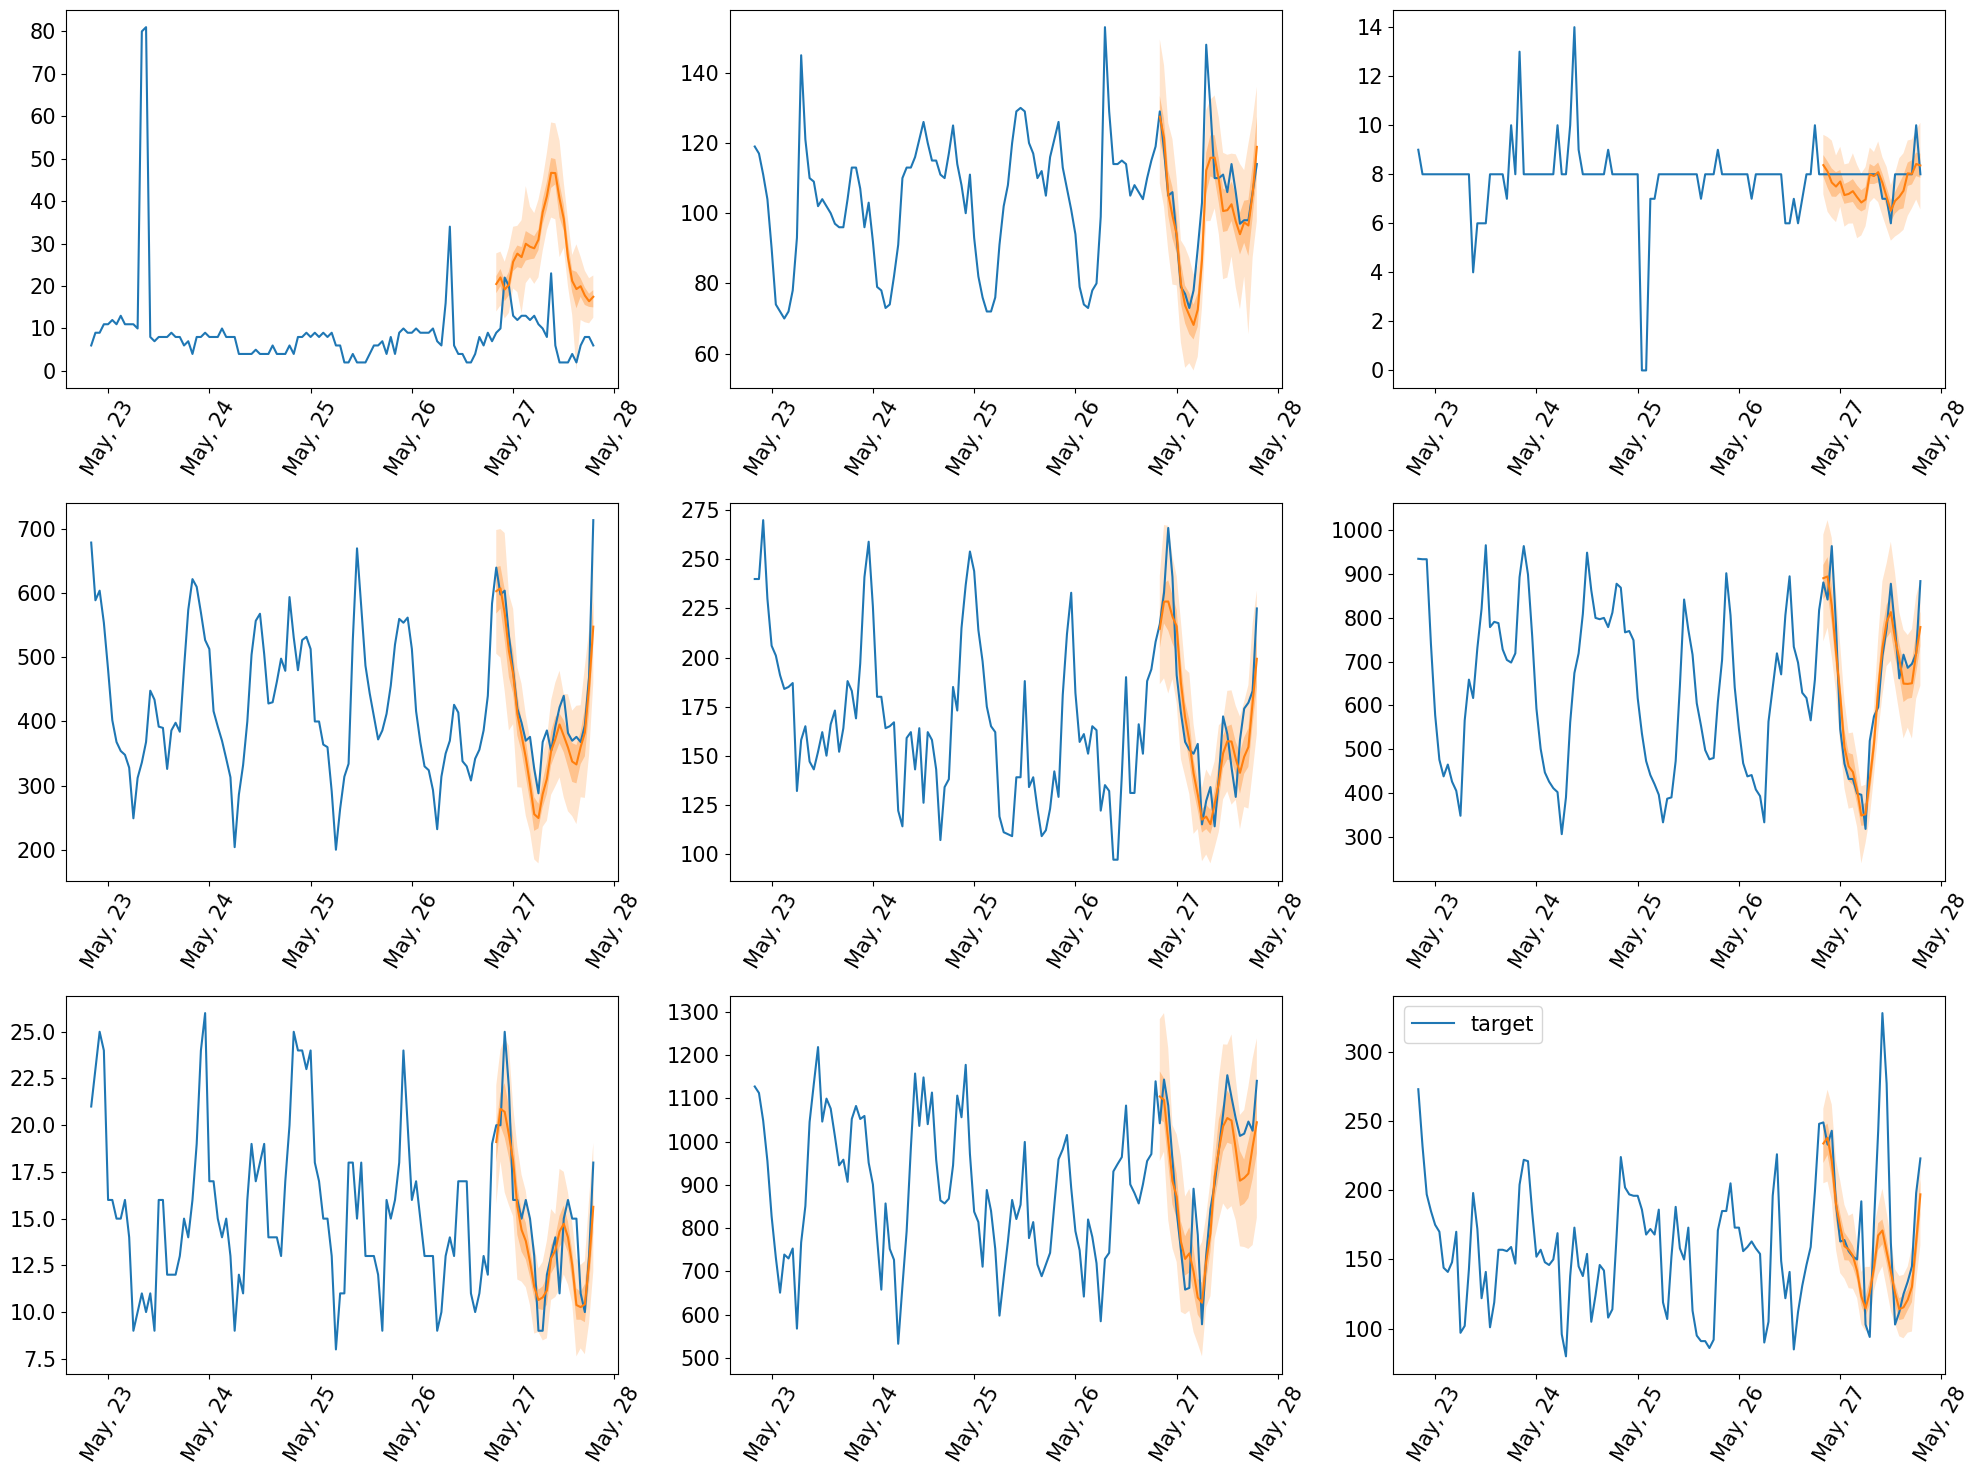

In [27]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-5 * prediction_length :].to_timestamp(), label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

And we can compute evaluation metrics, that summarize the performance of the model on our test data.

In [28]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [29]:
metrics_pytorch, _ = evaluator(tss_pytorch, forecasts_pytorch)
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()

Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 2247it [00:00, 27307.79it/s]

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


FeedForward
Coverage[0.1]               8.023661e-02
Coverage[0.5]               3.813047e-01
Coverage[0.9]               8.062787e-01
MAE_Coverage                3.687596e-01
MAPE                        1.447735e-01
MASE                        1.036059e+00
MSE                         3.990294e+06
MSIS                        8.700368e+00
ND                          9.813000e-02
NRMSE                       8.374609e-01
OWA                                  NaN
QuantileLoss[0.1]           5.321416e+06
QuantileLoss[0.5]           1.262275e+07
QuantileLoss[0.9]           7.478767e+06
RMSE                        1.997572e+03
abs_error                   1.262275e+07
abs_target_mean             2.385272e+03
abs_target_sum              1.286330e+08
mean_absolute_QuantileLoss  8.474312e+06
mean_wQuantileLoss          6.587979e-02
num_masked_target_values    0.000000e+00
sMAPE                       1.424586e-01
seasonal_error              1.894934e+02
wQuantileLoss[0.1]          4.136899e-02
wQuantileLoss[0.5]          9.813001e-02
wQuantileLoss[0.9]          5.814037e-02